# Tarea 1
## Gustavo Pinto

###### colaborado por Ean Paredes, Felipe Droguett, Maximiliano Jerez, Nicolas Correa

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sympy as sy
%matplotlib inline
import seaborn as sns

df_GDP= pd.read_excel("GDPC1.xls") #Importing Real GDP
df_BDS= pd.read_excel("Datamacro.xlsx", sheet_name=1) #Importing Business Dynamics Statistics (BDS)
df_BEA= pd.read_excel("Table.xlsx", header=4) #Importing Bureau of Economic Analysis (BEA)

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# 1.1 Comovimiento en la dinámica sectorial de firmas

<AxesSubplot:>

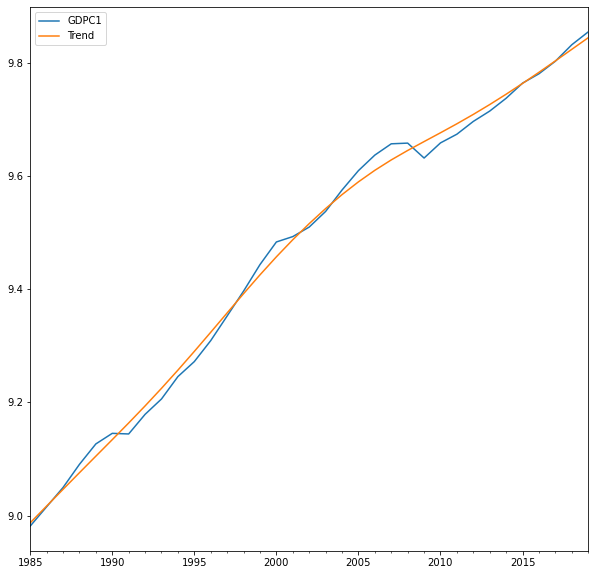

In [2]:
df_GDP['Year'] = df_GDP['observation_date'].dt.year #Convert dates to years
df_GDP=df_GDP.drop(["observation_date"], axis=1).dropna() #dropping na values

#Apply Ln

df_GDP["GDPC1"]=df_GDP["GDPC1"].apply(lambda x: np.log(x))

#Adjust Subsample of interest 1985/2019

df_GDP=df_GDP[df_GDP["Year"]>=1985]
df_GDP=df_GDP[df_GDP["Year"]<=2019]

#Apply HP Filter and plotting

index = pd.period_range(str(df_GDP.Year.iat[0]), str(df_GDP.Year.iat[-1]), freq='Y')
df_GDP.set_index(index, inplace=True)
cycle, trend= sm.tsa.filters.hpfilter(df_GDP["GDPC1"], 100)
df_GDP["Trend"]= trend
df_GDP["Cycle"]= cycle
df_GDP[["GDPC1", "Trend"]].plot(figsize=(10, 10))

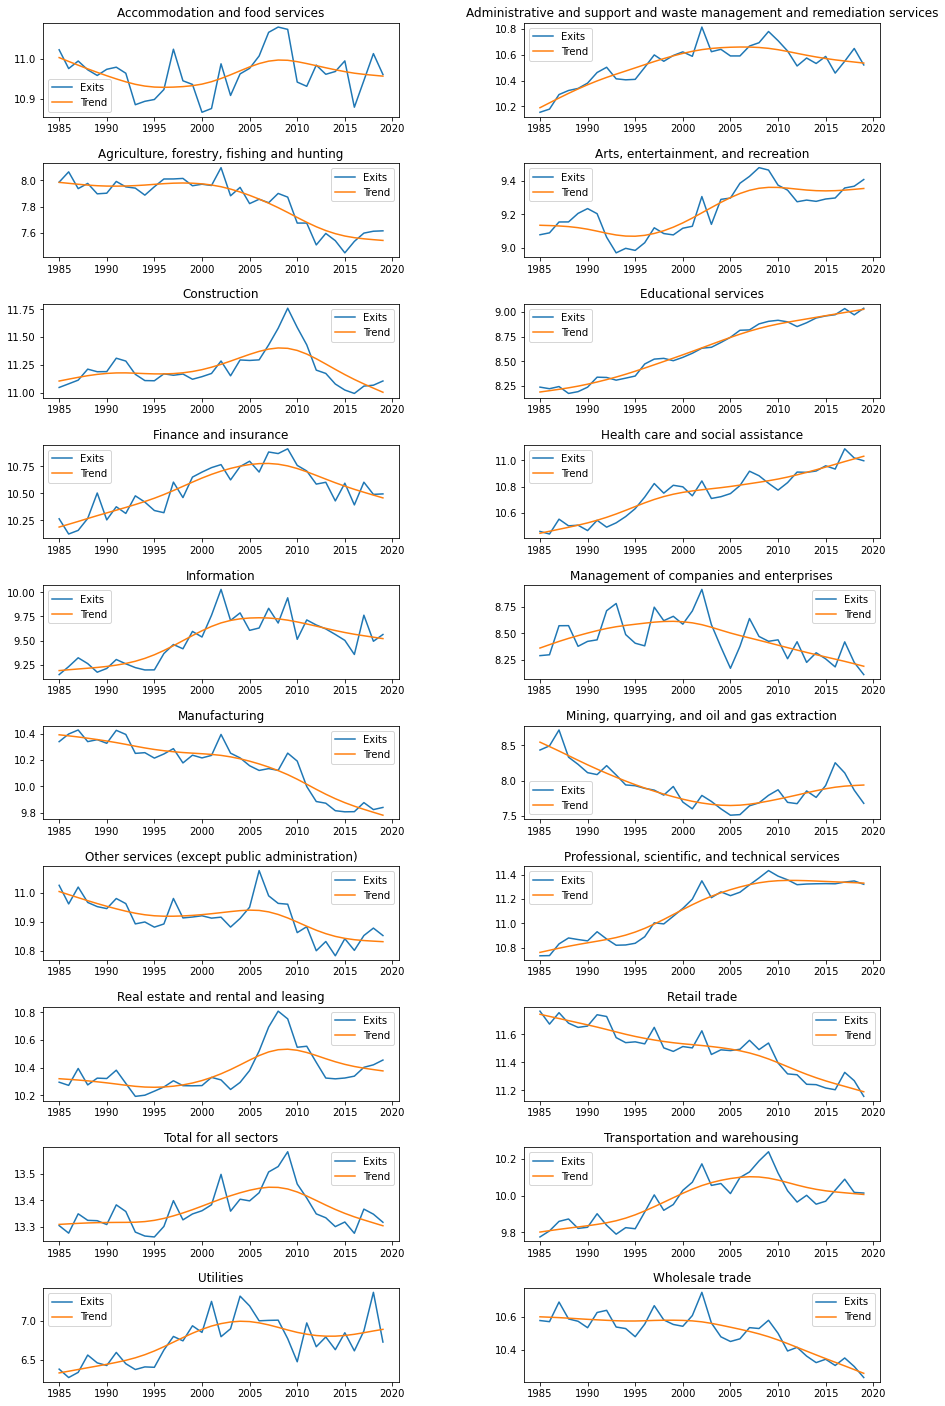

In [3]:
#Selecting rows of interest

df_BDS=(df_BDS[["Meaning of Establishment age code", "Year", "Number of establishments born during the last 12 months",
                "Number of establishments exited during the last 12 months",
                "Meaning of NAICS Code"]])

#Filtering Data

df_BDS= df_BDS[df_BDS['Meaning of Establishment age code']== "Total"]

#Convert Columns "Number of firms that exited during the last 12 months" to float type

df_BDS['Number of establishments exited during the last 12 months']= (
    df_BDS['Number of establishments exited during the last 12 months'].str.replace(",", ""))
df_BDS['Number of establishments exited during the last 12 months'] = (
    df_BDS['Number of establishments exited during the last 12 months'].astype(float))

#Convert Columns "Number of establishments exited during the last 12 months" to float type

df_BDS['Number of establishments born during the last 12 months']= (
    df_BDS['Number of establishments born during the last 12 months'].str.replace(",", ""))
df_BDS['Number of establishments born during the last 12 months'] = (
    df_BDS['Number of establishments born during the last 12 months'].astype(float))

#Convert Columns "Year" to int type

df_BDS['Year'] = df_BDS['Year'].astype(int)

df_BDS.reset_index(drop=True, inplace=True)

#Creating a dataframe with the dynamcics of exiting firms

df_exit=(
    df_BDS[["Meaning of NAICS Code", "Year", "Number of establishments exited during the last 12 months"]].
    pivot(index="Year",columns="Meaning of NAICS Code", values="Number of establishments exited during the last 12 months"))

#Apply Ln

df_exit=df_exit.apply(lambda x: np.log(x))

#Adjust Subsample of interest 1985/2019

df_exit=df_exit[df_exit.index>=1985]
df_exit=df_exit[df_exit.index<=2019]

#Apply HP Filter

for i in range (int(df_exit.shape[1])):
    cycle, trend=sm.tsa.filters.hpfilter(df_exit.iloc[:,i], 100)
    df_exit[str(i)+"Cycle"]=cycle
    df_exit[str(i)+"Trend"]=trend   

#Plotting

fig, axs = plt.subplots(10,2, figsize=(15,25))
fig.subplots_adjust(hspace = 0.5, wspace=.35)
axs = axs.ravel()
for i in range(20):
    axs[i].plot(df_exit.iloc[:,i])
    axs[i].plot(df_exit[str(i)+"Trend"])
    axs[i].set_title(str(df_exit.columns[i]))
    axs[i].legend(["Exits","Trend"]) 

<AxesSubplot:>

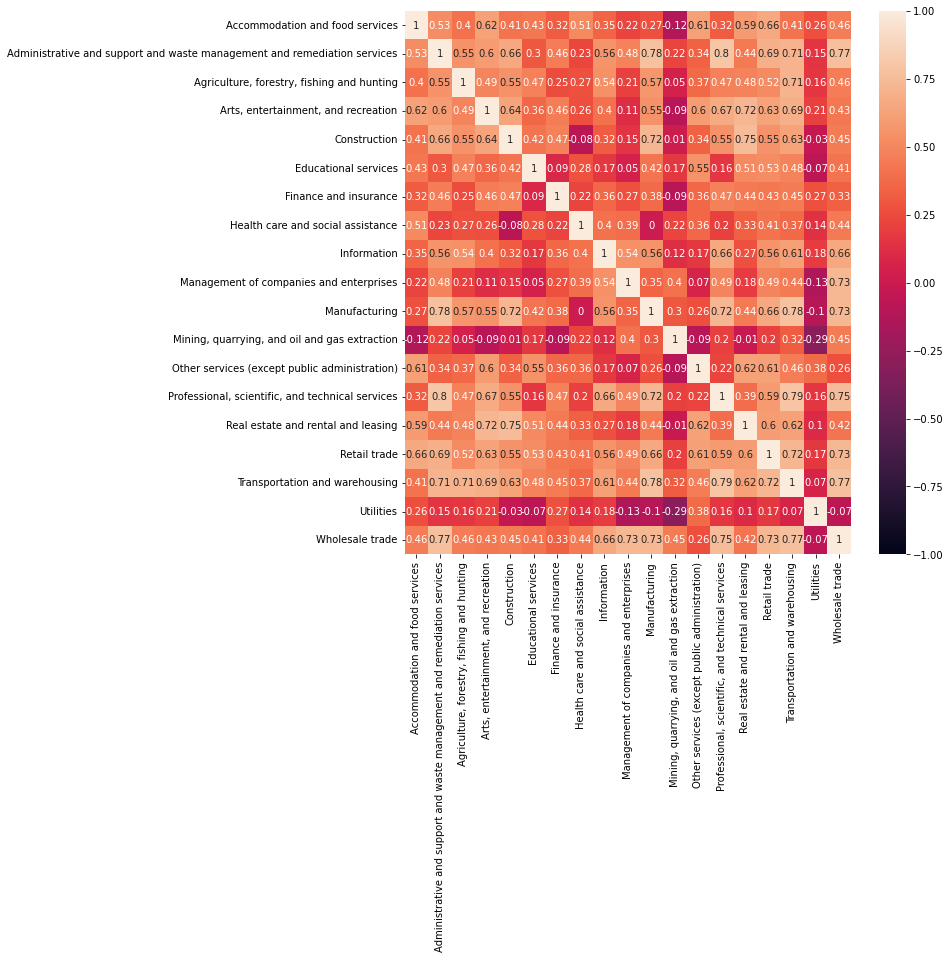

In [4]:
#Computing correlations between firms exit cycles


df_exit_corr=pd.DataFrame()

for i in range (20):
    df_exit_corr[i]=df_exit[[str(i)+"Cycle"]]
    df_exit_corr.rename(columns={i:df_exit.columns[i]}, inplace=True)
df_exit_corr=round(df_exit_corr.drop("Total for all sectors", axis=1).corr("pearson"),2)
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(df_exit_corr, vmin=-1, vmax=1, annot=True)

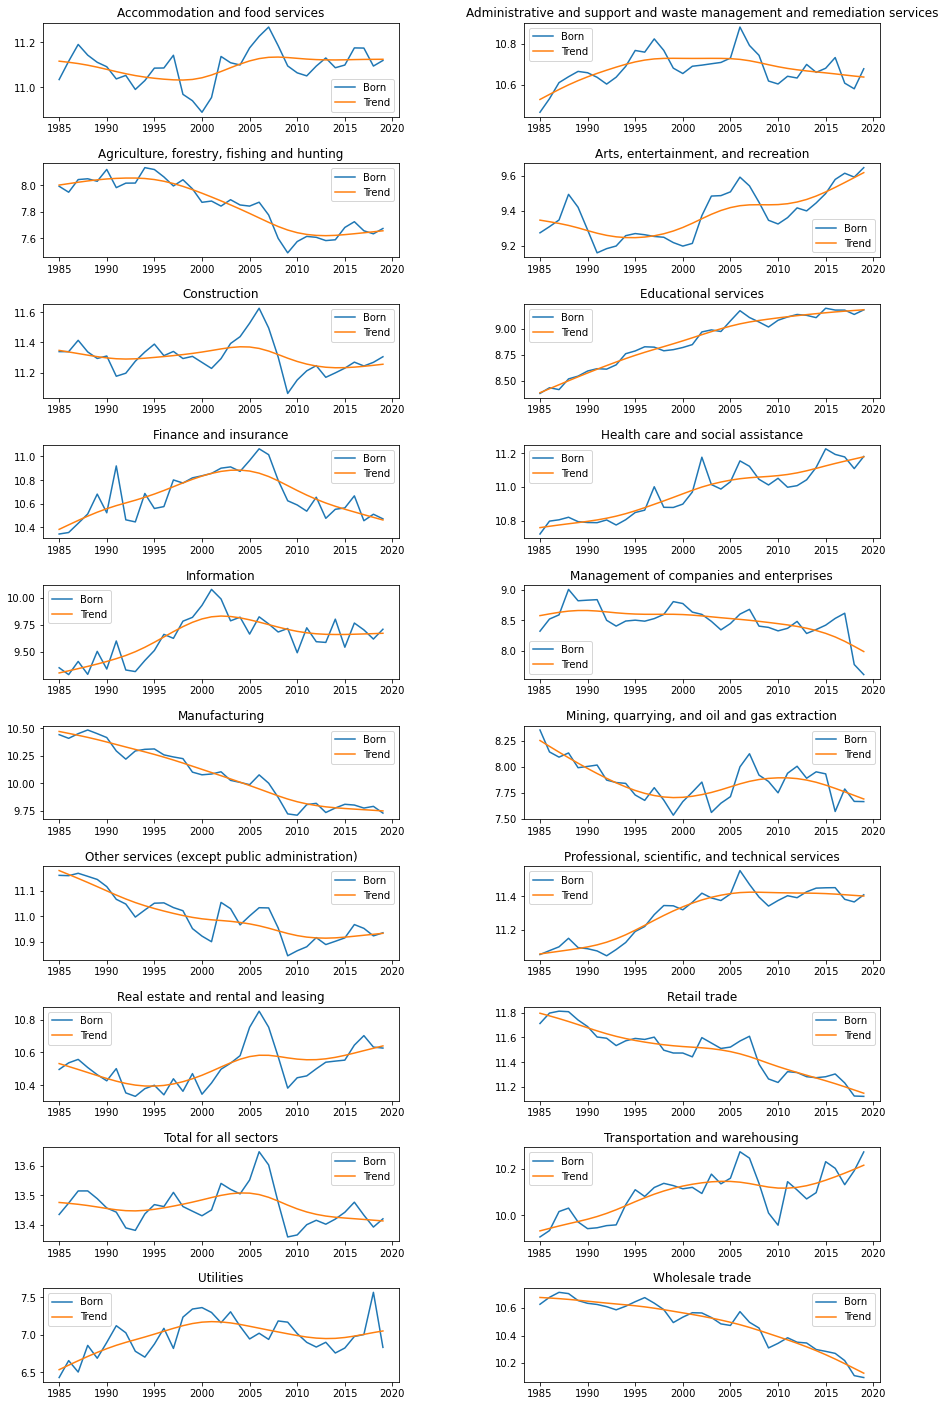

In [5]:
#Creating a dataframe with the dynamcics of born firms

df_entry=(
    df_BDS[["Meaning of NAICS Code", "Year", "Number of establishments born during the last 12 months"]])

df_entry=(df_entry.
          pivot(index="Year",
                columns="Meaning of NAICS Code", values="Number of establishments born during the last 12 months"))

#Apply Ln
df_entry=df_entry.apply(lambda x: np.log(x))

#Adjust Subsample of interest 1985/2019
df_entry=df_entry[df_entry.index>=1985]
df_entry=df_entry[df_entry.index<=2019]

#Apply HP Filter
for i in range (int(df_entry.shape[1])):
    cycle, trend=sm.tsa.filters.hpfilter(df_entry.iloc[:,i], 100)
    df_entry[str(i)+"Cycle"]=cycle
    df_entry[str(i)+"Trend"]=trend   

#Plotting
fig, axs = plt.subplots(10,2, figsize=(15,25))
fig.subplots_adjust(hspace = 0.5, wspace=.35)
axs = axs.ravel()
for i in range(20):
    axs[i].plot(df_entry.iloc[:,i])
    axs[i].plot(df_entry[str(i)+"Trend"])
    axs[i].set_title(str(df_entry.columns[i]))
    axs[i].legend(["Born","Trend"]) 

<AxesSubplot:>

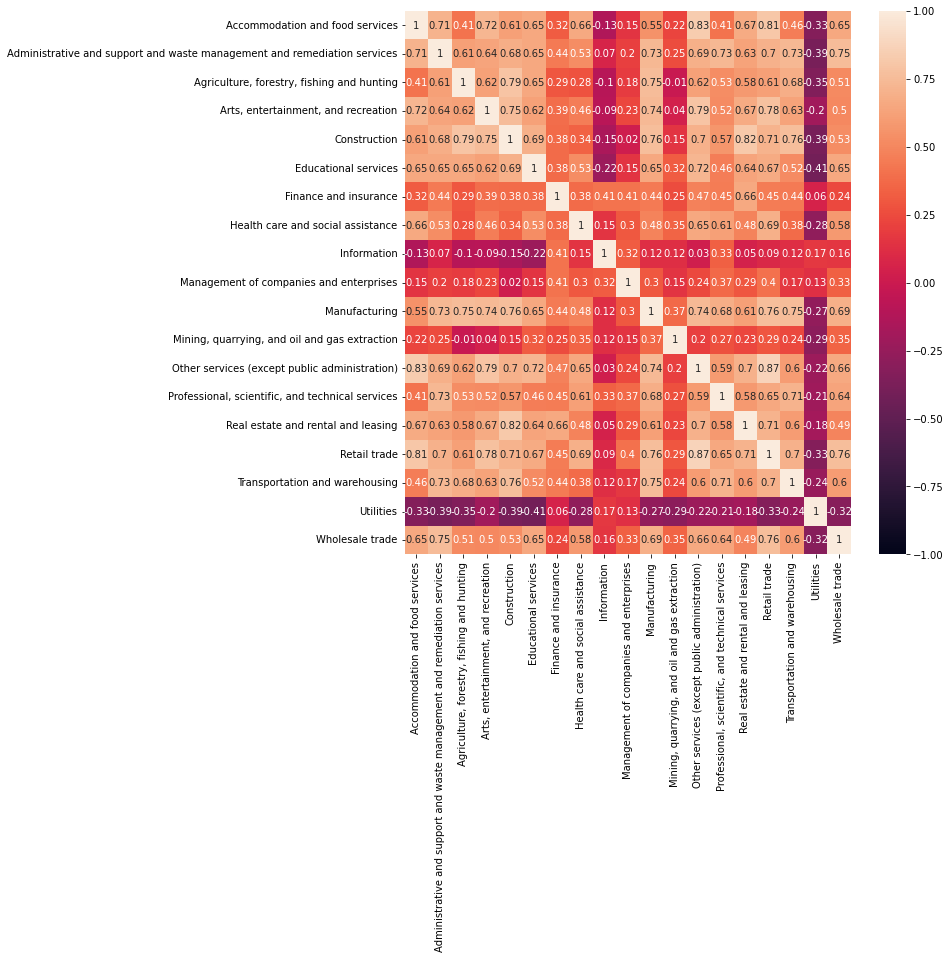

In [6]:
#Computing correlations between firms entries

df_entry_corr=pd.DataFrame()

for i in range (20):
    df_entry_corr[i]=df_entry[[str(i)+"Cycle"]]
    df_entry_corr.rename(columns={i:df_entry.columns[i]}, inplace=True)
df_entry_corr=round(df_entry_corr.drop("Total for all sectors", axis=1).corr("pearson"),2)
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(df_entry_corr, vmin=-1, vmax=1, annot=True)

In [7]:
#Computing correlations between GDP Cycle and firm entries and exits cycles

df_corr=pd.DataFrame()
df_corr["GDP Cycle"]=df_GDP.set_index("Year").Cycle
df_corr["Exit Cycle"]=df_exit["16Cycle"]
df_corr["Entry Cycle"]=df_entry["16Cycle"]

round(df_corr.corr("pearson"),2)

,GDP Cycle,Exit Cycle,Entry Cycle
GDP Cycle,1.00,-0.05,0.56
Exit Cycle,-0.05,1.00,-0.09
Entry Cycle,0.56,-0.09,1.00


## 1.1.1

Como podemos ver, el ciclo del GDP se correlaciona positivamente con la entrada de firmas y negativamente con la salida de firmas. Esto hace sentido ya que, uno podria esperar que en los ciclos de alza del GDP deben haber mas firmas dispuestas a entrar en el mercado debido al boom economico y este, a su vez, impulsar el GDP al alza por las nuevas firmas que entran. Lo mismo se puede decir al contrario pero con una particularidad. Como se puede ver, el ciclo del GDP y la salidas de firmas estan ligeramente correlacionadas de manera negativa (-0.05). Esto implica que a pesar de que el signo es el esperado, la magnitud es considerablemente pequeña. La implicancia de la cifra puede hacernos entender que en tiempos de estancamiento economico, el numero de firmas que salen son muy pocas. La principal diferencia es que el ciclo economico esta correlacionado con signos opuestos entre las entradas y salidas de firmas. Ademas, la magnitud de la correlacion es mas fuerte para la entrada que para las salidas.

Una explicacion para la diferencia de magnitud puede ser que las firmas que entran pueden ser de 2 tipos: las que salieron de un sector y entraron a otro o, las firmas nuevas que entraron en la economia. Se puede pensar que en un momento de depresion economica, las firmas mas que salir del mercado, sencillamente se cambian de industria. Por esta razon la magnitud de correlacion de entrada y salida es considerable la diferencia.

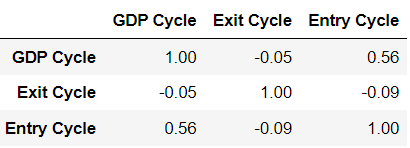

## 1.1.2

Se puede observar en el grafico a continuacion existe correlacion entre la entrada y salida de firmas en distintos sectores. La correlacion de salida de firmas por sector se ve asi:

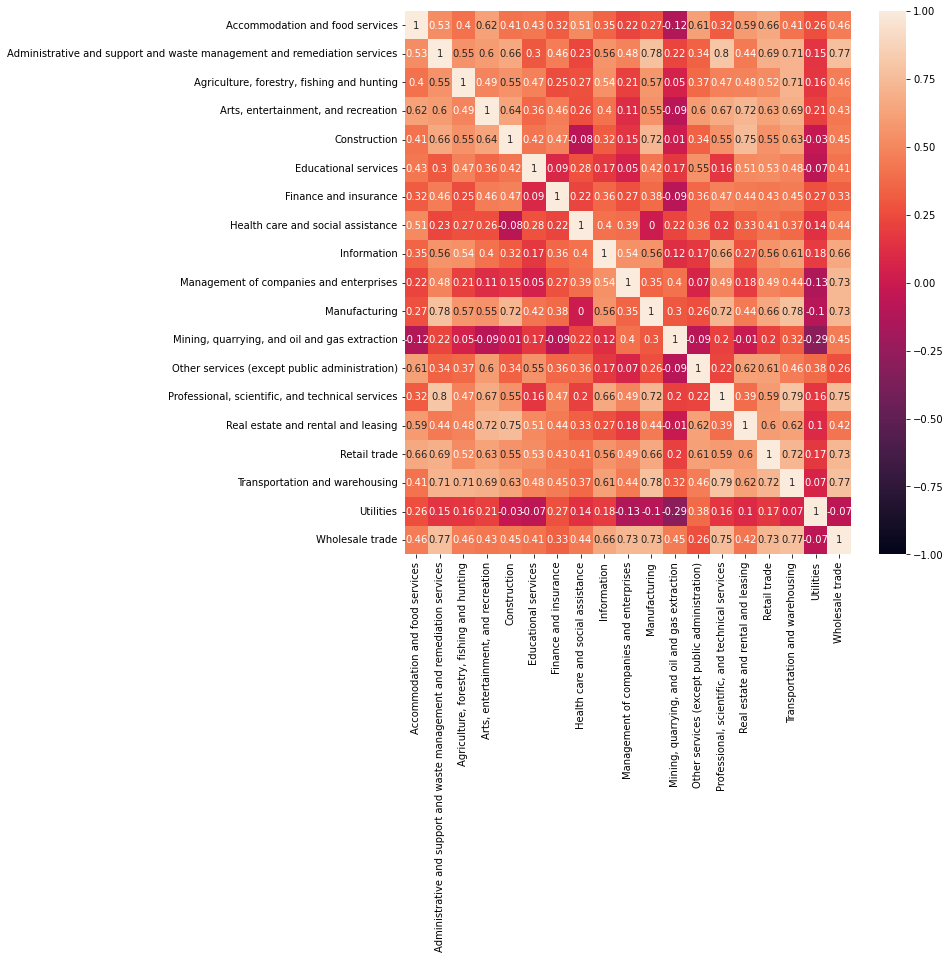

Por ejemplo, el sector wholesale Trade tiene una alta correlacion con los sectores Retail Trade y Transportation and warehousing. Las industrias con menor correlacion de salida con el resto de industrias son: Mining, quarrying and, oil and gas extraction y Utilities. Las demas industrias presentan cierto grado de correlacion en sus salidas.

La correlacion de entradas de firmas por sector industrial tiene la siguiente forma:

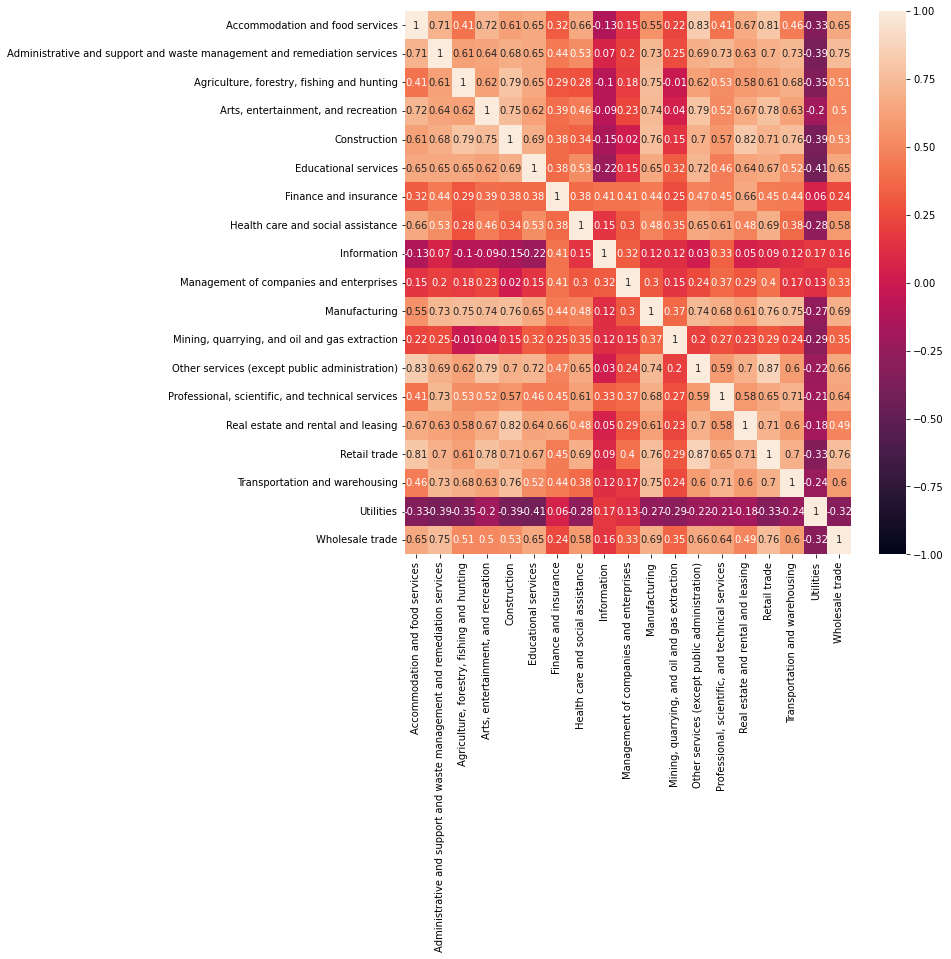


De nuevo vemos que Wholesale trade y Retail trade tienen una alta correlacion entre ellas. En general, las industrias Information y Utilities presentan las menores correlaciones con el resto de la economia.

En conclusion podemos ver que la entrada y salida de firmas en distintos sectores de la economia estan bastante bien relacionadas. Esto demuestra cierto grado de conexion entre las diversas industrias.

# 1.2 Conexiones de insumo-producto entre pares de sectores y dinamica de firmas sectoriales

In [8]:
#Cleaning and filtering the data from BEA


df_BEA.drop(df_BEA.columns[0], axis=1)
df_BEA.columns = df_BEA.iloc[1]
df_BEA.drop(1, inplace=True)
df_BEA.drop(df_BEA.columns[0],axis=1,inplace=True)
df_BEA.rename(columns={"Name":"Commodities/Industries"}, inplace=True)
df_BEA.drop(0, inplace=True)
df_BEA.set_index("Commodities/Industries", inplace=True)
df_BEA=df_BEA.T
df_BEA=df_BEA.replace("---", 0)
df_BEA.drop(["Scrap, used and secondhand goods","Noncomparable imports and rest-of-the-world adjustment"],
            axis=1, inplace=True)
df_BEA.index=df_BEA.index.rename(None)

#Aggregating Data from BDS and matching it with BEA Data For entry

df_entry_corr=pd.DataFrame()

for i in range (20):
    df_entry_corr[i]=df_entry[[str(i)+"Cycle"]]
    df_entry_corr.rename(columns={i:df_entry.columns[i]}, inplace=True)

df_entry_corr["Arts, entertainment, recreation, accommodation, and food services"]=(
    df_entry["Accommodation and food services"] + df_entry["Health care and social assistance"])
df_entry_corr["Educational services, health care, and social assistance"]=(
    df_entry["Educational services"] + df_entry["Arts, entertainment, and recreation"])
df_entry_corr["Finance, insurance, real estate, rental, and leasing"]=(
    df_entry["Finance and insurance"] + df_entry["Real estate and rental and leasing"])
df_entry_corr["Other services, except government"]=(
    df_entry["Other services (except public administration)"] + 
    df_entry["Administrative and support and waste management and remediation services"])
df_entry_corr["Professional and business services"]=(
    df_entry["Professional, scientific, and technical services"] + df_entry["Management of companies and enterprises"])
df_entry_corr.drop(["Accommodation and food services", 
                    "Arts, entertainment, and recreation",
                    "Health care and social assistance", "Educational services",
                    "Real estate and rental and leasing", "Finance and insurance", 
                    "Administrative and support and waste management and remediation services",
                    "Other services (except public administration)",
                    "Management of companies and enterprises", 
                    "Professional, scientific, and technical services",
                    "Total for all sectors"], axis=1, inplace=True)
df_entry_corr.rename(
    columns=({"Mining, quarrying, and oil and gas extraction":"Mining",
              "Agriculture, forestry, fishing and hunting": "Agriculture, forestry, fishing, and hunting"}), inplace=True)

#Creating Matrix Correlations for entry cycles

entry_corr=np.zeros((df_entry_corr.corr("pearson").shape))

for col in range (df_entry_corr.corr("pearson").shape[1]):
    for row in range (df_entry_corr.corr("pearson").shape[0]):
        if col==row:
            entry_corr[row,col]= None
        if col!=row:
            entry_corr[row,col]= df_entry_corr.corr("pearson").iloc[row,col]
            
df_entry_corr=pd.DataFrame(entry_corr, columns=df_entry_corr.columns)

#Aggregating Data from BDS and matching it with BEA Data For exit

df_exit_corr=pd.DataFrame()

for i in range (20):
    df_exit_corr[i]=df_exit[[str(i)+"Cycle"]]
    df_exit_corr.rename(columns={i:df_exit.columns[i]}, inplace=True)

df_exit_corr["Arts, entertainment, recreation, accommodation, and food services"]=(
    df_exit["Accommodation and food services"] + df_exit["Health care and social assistance"])
df_exit_corr["Educational services, health care, and social assistance"]=(
    df_exit["Educational services"] + df_exit["Arts, entertainment, and recreation"])
df_exit_corr["Finance, insurance, real estate, rental, and leasing"]=(
    df_exit["Finance and insurance"] + df_exit["Real estate and rental and leasing"])
df_exit_corr["Other services, except government"]=(
    df_exit["Other services (except public administration)"] + 
    df_exit["Administrative and support and waste management and remediation services"])
df_exit_corr["Professional and business services"]=(
    df_exit["Professional, scientific, and technical services"] + df_exit["Management of companies and enterprises"])
df_exit_corr.drop(["Accommodation and food services", 
                   "Arts, entertainment, and recreation",
                   "Health care and social assistance", 
                   "Educational services",
                   "Real estate and rental and leasing", 
                   "Finance and insurance", 
                   "Administrative and support and waste management and remediation services",
                   "Other services (except public administration)",
                   "Management of companies and enterprises", 
                   "Professional, scientific, and technical services",
                   "Total for all sectors"], axis=1, inplace=True)

df_exit_corr.rename(
    columns=({"Mining, quarrying, and oil and gas extraction":"Mining",
              "Agriculture, forestry, fishing and hunting": "Agriculture, forestry, fishing, and hunting"}), inplace=True)

#Creating Matrix Correlations for exit cycles

exit_corr=np.zeros((df_exit_corr.corr("pearson").shape))

for col in range (df_exit_corr.corr("pearson").shape[1]):
    for row in range (df_exit_corr.corr("pearson").shape[0]):
        if col==row:
            exit_corr[row,col]= None
        if col!=row:
            exit_corr[row,col]= df_exit_corr.corr("pearson").iloc[row,col]
            
df_exit_corr=pd.DataFrame(exit_corr, columns=df_exit_corr.columns)


## NOTA:

Para trabajar con tanto con los datos de la BEA y la BDS, se tuvo que agregar las 19 industrias de la BDS a las 15 de la BEA. El mapeo fue el siguiente:

- "Arts, entertainment, recreation, accommodation, and food services" de la BEA = "Accommodation and food services" y "Health care and social assistance" de la BDS

- "Educational services, health care, and social assistance" de la BEA = "Educational services" y"Arts, entertainment, and recreation" de la BDS

- "Finance, insurance, real estate, rental, and leasing" de la BEA = "Finance and insurance" y"Real estate and rental and leasing" de la BDS

- "Professional and business services" de la BEA = "Professional, scientific, and technical services" y "Management of companies and enterprises" de la BDS

- "Other services, except government"] de la BEA = "Other services (except public administration)" y "Administrative and support and waste management and remediation services" de la BDS

El criterio para las primeras 3 agregaciones de industrias obedece a sencillamente agrupar lo que estaba separado en nombres en la BDS y agruparlo como el nombre lo indica en la BEA

El criterio para las ultimas 2 agregaciones fue de tratar de agrupar por los rubros que fuesen mas similares. Por ejemplo, 
Other services, except government de la BEA lo entedimos como una industria que toma en cuenta todo lo que no se toma en consideracion.

Por ultimo, se le hizo un pequeño cambio de nombre a "Mining, quarrying, and oil and gas extraction" y "Agriculture, forestry, fishing and hunting" de la BDS para que coincideran con los de la BEA.

Con respecto al sector gobierno, al este no encontrarse dentro de la BDS como una industria, procedimos a eliminar todas las observaciones relacionadas con "Government"


Text(0, 0.5, 'Average Conectivity')

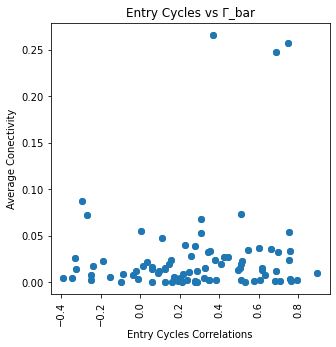

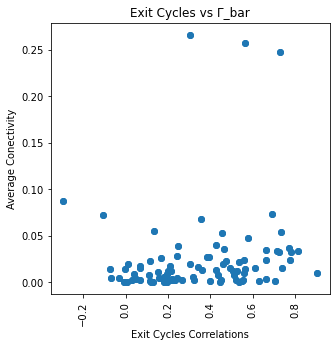

In [9]:
#Creating the Ratios of expenditures γ, Γ Matrix

ratios_expenditures=np.zeros((df_BEA.index.get_loc("Total Intermediate"),df_BEA.columns.get_loc("Total Intermediate")))
for col in range (df_BEA.columns.get_loc("Total Intermediate")):
    for row in range (df_BEA.index.get_loc("Total Intermediate")):
        if col==row:
            ratios_expenditures[row,col]= (df_BEA.iloc[row,col]/
                                           df_BEA.iloc[df_BEA.index.get_loc("Total use of products"),col])
        if col<row:
            ratios_expenditures[row,col]=(df_BEA.iloc[row,col]/
                                          df_BEA.iloc[df_BEA.index.get_loc("Total use of products"),col])
        if col>row:
            ratios_expenditures[row,col]=(df_BEA.iloc[row,col]/
                                          df_BEA.iloc[df_BEA.index.get_loc("Total use of products"),col])
df_ratios_expenditures=(
    pd.DataFrame(ratios_expenditures, columns= (df_BEA.columns[:df_BEA.columns.get_loc("Total Intermediate")])))
df_ratios_expenditures=(
    df_ratios_expenditures.
    apply(lambda x: round(x, 4)).set_index(df_BEA.index[:df_BEA.index.get_loc("Total Intermediate")]))

#Creating the average Ratios of conectivity γ_bar Matrix

average_conectivity=np.zeros(df_ratios_expenditures.shape)
for col in range (df_ratios_expenditures.shape[1]):
    for row in range (df_ratios_expenditures.shape[0]):
        if col==row:
            average_conectivity[row,col]= None
        if col!=row:
            average_conectivity[row,col]= (df_ratios_expenditures.iloc[row,col]+df_ratios_expenditures.iloc[col,row])/2

df_average_conectivity= pd.DataFrame(average_conectivity, columns= df_ratios_expenditures.columns)
df_average_conectivity=df_average_conectivity.apply(lambda x: round(x, 4)).set_index(df_ratios_expenditures.index)

#Plotting Scatter plots

fig, axs = plt.subplots(figsize=(5,5))

x=(
    df_entry_corr.reindex(sorted(df_entry_corr), axis=1).
    set_index(df_entry_corr.columns).sort_index().melt().value)
y=(
    df_average_conectivity.sort_index().
    reindex(sorted(df_average_conectivity), axis=1).drop("Government", axis=1).drop("Government").melt().value)
plt.scatter(x,y)

plt.xticks(rotation = 90)
plt.title("Entry Cycles vs Γ_bar")
plt.xlabel("Entry Cycles Correlations")
plt.ylabel("Average Conectivity")


fig, axs = plt.subplots(figsize=(5,5))

x=(
    df_exit_corr.reindex(sorted(df_exit_corr), axis=1).
   set_index(df_exit_corr.columns).sort_index().melt().value)
y=(
    df_average_conectivity.sort_index().
    reindex(sorted(df_average_conectivity), axis=1).drop("Government", axis=1).drop("Government").melt().value)

plt.scatter(x,y)
plt.xticks(rotation = 90)
plt.title("Exit Cycles vs Γ_bar")
plt.xlabel("Exit Cycles Correlations")
plt.ylabel("Average Conectivity")

# 1.2.1

Aca calculamos la matriz $\Gamma$ los elementos de dicha matriz vienen calculados por:

$$\gamma_{ij}= \frac{P_jM_{ij}}{P_iQ_i}$$

La matriz mide el share de gastos de bienes intermedios de las industrias. Esta mide la progagacion upstream, es decir, el share de influencia que tiene una industria por otras.

A partir de esta, se procede a construir la la matriz de conectividad promedio $\overline{\Gamma}$ compuesto de los elementos:

$$\overline{\gamma}_{ij}= \frac{1}{2}(\gamma_{ij}+\gamma_{ji})$$

Esta mide la conectividad promedio entre las industrias

Se puede observar que la relacion parece ser bastante constante tanto para entrada y salidas con la conectividad promedio upstream de las firmas.

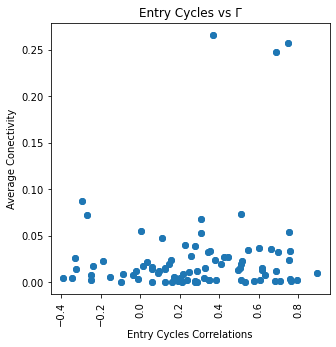

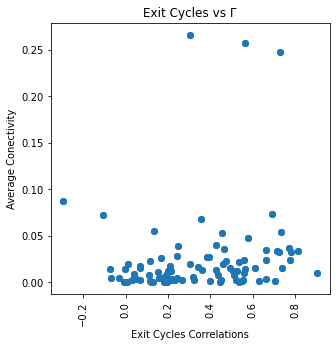



Text(0, 0.5, 'Average Conectivity Propagation')

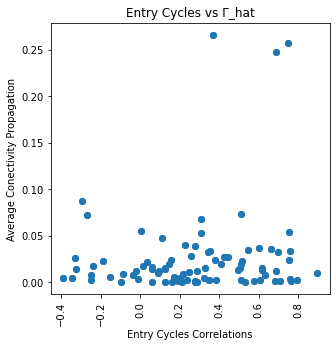

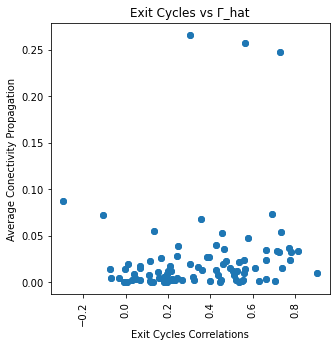

In [10]:
#Creating the Ratios of expenditures γ_tilde, Γ_tilde Matrix

ratios_expenditures_bar=(
    np.zeros((df_BEA.index.get_loc("Total Intermediate"),df_BEA.columns.get_loc("Total Intermediate"))))
for col in range (df_BEA.columns.get_loc("Total Intermediate")):
    for row in range (df_BEA.index.get_loc("Total Intermediate")):
        if col==row:
            ratios_expenditures_bar[row,col]= (
                df_BEA.iloc[row,col]/df_BEA.iloc[df_BEA.columns.get_loc("Total industry output (basic prices)"),col])
        if col<row:
            ratios_expenditures_bar[row,col]=(
                df_BEA.iloc[row,col]/df_BEA.iloc[df_BEA.columns.get_loc("Total industry output (basic prices)"),col])
        if col>row:
            ratios_expenditures_bar[row,col]=(
                df_BEA.iloc[row,col]/df_BEA.iloc[df_BEA.columns.get_loc("Total industry output (basic prices)"),col])
df_ratios_expenditures_bar= (
    pd.DataFrame(ratios_expenditures_bar, columns= df_BEA.columns[:df_BEA.columns.get_loc("Total Intermediate")]))
df_ratios_expenditures_bar=(
    df_ratios_expenditures_bar.apply(lambda x: round(x, 4)).
    set_index(df_BEA.index[:df_BEA.index.get_loc("Total Intermediate")]))

#Creating the average Ratios of conectivity γ_tilde Matrix

average_conectivity_bar=np.zeros(df_ratios_expenditures_bar.shape)
for col in range (df_ratios_expenditures_bar.shape[1]):
    for row in range (df_ratios_expenditures_bar.shape[0]):
        if col==row:
            average_conectivity_bar[row,col]= None
        if col!=row:
            average_conectivity_bar[row,col]= (
                (df_ratios_expenditures_bar.iloc[row,col]+df_ratios_expenditures_bar.iloc[col,row])/2)

df_average_conectivity_bar= pd.DataFrame(average_conectivity_bar, columns= df_ratios_expenditures_bar.columns)
df_average_conectivity_bar= (
    df_average_conectivity_bar.apply(lambda x: round(x, 4)).set_index(df_ratios_expenditures_bar.index))

#Plotting Scatter plots

fig, axs = plt.subplots(figsize=(5,5))

x=df_entry_corr.reindex(sorted(df_entry_corr), axis=1).set_index(df_entry_corr.columns).sort_index().melt().value
y=(
    df_average_conectivity_bar.sort_index().
    reindex(sorted(df_average_conectivity_bar), axis=1).drop("Government", axis=1).drop("Government").melt().value)

plt.scatter(x,y)

plt.xticks(rotation = 90)
plt.title("Entry Cycles vs Γ_hat")
plt.xlabel("Entry Cycles Correlations")
plt.ylabel("Average Conectivity Propagation")

fig, axs = plt.subplots(figsize=(5,5))

x=df_exit_corr.reindex(sorted(df_exit_corr), axis=1).set_index(df_exit_corr.columns).sort_index().melt().value
y=(
    df_average_conectivity_bar.sort_index().
    reindex(sorted(df_average_conectivity_bar), axis=1).drop("Government", axis=1).drop("Government").melt().value)

plt.scatter(x,y)

plt.xticks(rotation = 90)
plt.title("Exit Cycles vs Γ_hat")
plt.xlabel("Exit Cycles Correlations")
plt.ylabel("Average Conectivity Propagation")

# 1.2.2

En este caso procedimos a construir la matriz $\tilde{\Gamma}$, esta consiste de:

$$\tilde{\gamma}_{ij}=\frac{P_jM_{ij}}{P_jQ_j}$$

Esta mide la progagacion de downstream, es decir, el share de influencia que tiene una industria sobre otra.

A continuacion, se procede a construir la conexion promedio $\hat{\Gamma}$ esta consta de:

$$\hat{\gamma}_{ij}= \frac{1}{2}(\tilde{\gamma}_{ij}+\tilde{\gamma}_{ji})$$

De nuevo, vemos que la relacion tanto de entrada y salida de firmas es bastante constante y no cambia con la conectividad promedio downstream

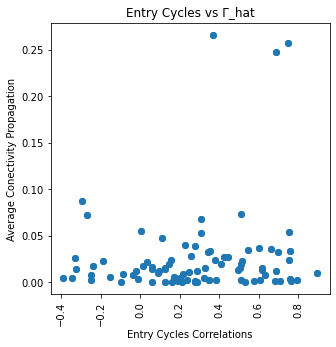

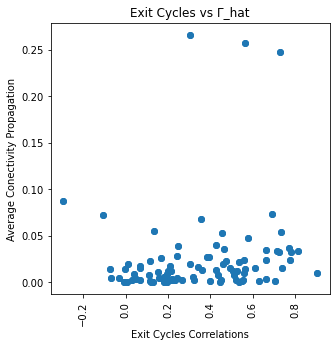

Text(0, 0.5, 'average Ratios of indirect conectivity upstream')

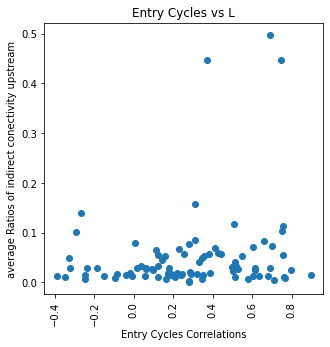

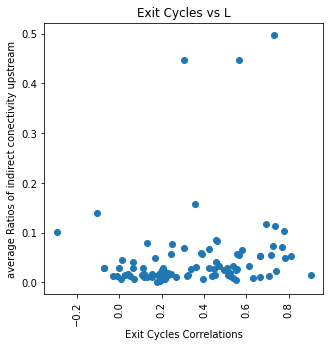

In [11]:
#Calculating Leontief Matrix L

Leontief= (np.identity(df_ratios_expenditures.to_numpy().shape[0])-df_ratios_expenditures.to_numpy())
df_Leontief=(
    pd.DataFrame(np.linalg.inv(Leontief),index=df_ratios_expenditures.index, columns=df_ratios_expenditures.columns))

#Calculating the average indirects conectivity in Leontief

average_Leontief=np.zeros(df_Leontief.shape)
for col in range (df_Leontief.shape[1]):
    for row in range (df_Leontief.shape[0]):
        if col==row:
            average_Leontief[row,col]= None
        if col<row:
            average_Leontief[row,col]= (df_Leontief.iloc[row,col]+df_Leontief.iloc[col,row])/2
        if col>row:
            average_Leontief[row,col]=None

df_average_Leontief= pd.DataFrame(average_Leontief, columns= df_Leontief.columns)
df_average_Leontief= df_average_Leontief.apply(lambda x: round(x, 4)).set_index(df_Leontief.index)

#Plotting Scatter plots

fig, axs = plt.subplots(figsize=(5,5))

x=df_entry_corr.reindex(sorted(df_entry_corr), axis=1).set_index(df_entry_corr.columns).sort_index().melt().value
y=(
    df_average_Leontief.sort_index().
    reindex(sorted(df_average_Leontief), axis=1).drop("Government", axis=1).drop("Government").melt().value)

plt.scatter(x,y)

plt.xticks(rotation = 90)
plt.title("Entry Cycles vs L")
plt.xlabel("Entry Cycles Correlations")
plt.ylabel("average Ratios of indirect conectivity upstream")

fig, axs = plt.subplots(figsize=(5,5))

x=df_exit_corr.reindex(sorted(df_exit_corr), axis=1).set_index(df_exit_corr.columns).sort_index().melt().value
y=(df_average_Leontief.sort_index().
   reindex(sorted(df_average_Leontief), axis=1).drop("Government", axis=1).drop("Government").melt().value)

plt.scatter(x,y)

plt.xticks(rotation = 90)
plt.title("Exit Cycles vs L")
plt.xlabel("Exit Cycles Correlations")
plt.ylabel("average Ratios of indirect conectivity upstream")


Text(0, 0.5, 'average Ratios of indirect conectivity Propagation downstream')

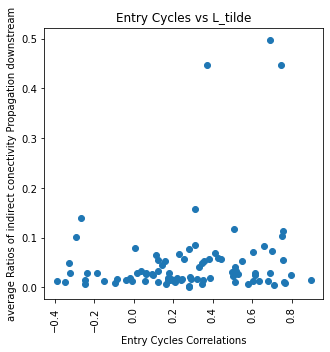

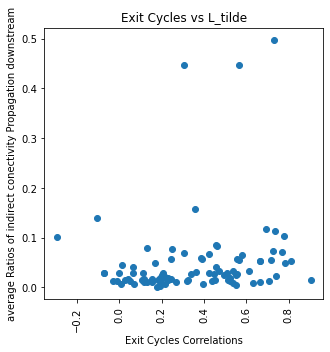

In [12]:
#Calculating Leontief_tilde Matrix L_tilde

Leontief_bar= (np.identity(df_ratios_expenditures_bar.to_numpy().shape[0])-df_ratios_expenditures_bar.to_numpy())
df_Leontief_bar=(
    pd.DataFrame(np.linalg.inv(Leontief_bar),index=(
        df_ratios_expenditures_bar.index), columns=df_ratios_expenditures_bar.columns))

#Calculating the average indirects conectivity in Leontief_bar

average_Leontief_bar=np.zeros(df_Leontief_bar.shape)
for col in range (df_Leontief_bar.shape[1]):
    for row in range (df_Leontief_bar.shape[0]):
        if col==row:
            average_Leontief_bar[row,col]= None
        if col<row:
            average_Leontief_bar[row,col]= (df_Leontief_bar.iloc[row,col]+df_Leontief_bar.iloc[col,row])/2
        if col>row:
            average_Leontief_bar[row,col]=None

df_average_Leontief_bar= pd.DataFrame(average_Leontief_bar, columns= df_Leontief_bar.columns)
df_average_Leontief_bar=df_average_Leontief_bar.apply(lambda x: round(x, 4)).set_index(df_Leontief_bar.index)

#Plotting Scatter plots

fig, axs = plt.subplots(figsize=(5,5))

x=df_entry_corr.reindex(sorted(df_entry_corr), axis=1).set_index(df_entry_corr.columns).sort_index().melt().value
y=(
    df_average_Leontief_bar.sort_index().
    reindex(sorted(df_average_Leontief_bar), axis=1).drop("Government", axis=1).drop("Government").melt().value)

plt.scatter(x,y)

plt.xticks(rotation = 90)
plt.title("Entry Cycles vs L_tilde")
plt.xlabel("Entry Cycles Correlations")
plt.ylabel("average Ratios of indirect conectivity Propagation downstream")

fig, axs = plt.subplots(figsize=(5,5))

x=df_exit_corr.reindex(sorted(df_exit_corr), axis=1).set_index(df_exit_corr.columns).sort_index().melt().value
y=(
    df_average_Leontief_bar.sort_index().
    reindex(sorted(df_average_Leontief_bar), axis=1).drop("Government", axis=1).drop("Government").melt().value)

plt.scatter(x,y)

plt.xticks(rotation = 90)
plt.title("Exit Cycles vs L_tilde")
plt.xlabel("Exit Cycles Correlations")
plt.ylabel("average Ratios of indirect conectivity Propagation downstream")

# 1.2.3

Ahora, construimos 2 matrices. La inversa de la matriz de Leontief upstream $L$ y downstream $\tilde{L}$.

Estas consisten en:

$$L=(I-\Gamma)$$ y
$$\tilde{L}=(1-\tilde{\Gamma})$$

Estas miden la conexion indirecta entre industrias upstrean y downstream correspondientemente.

A partir de estas matrices, revisaremos las conexiones promedios indirectas:

$$L_{ij}=\frac{1}{2}(l_{ij}+l_{ji})$$ y
$$\tilde{L}_{ij}=\frac{1}{2}(\tilde{l}_{ij}+\tilde{l}_{ji})$$

Encontramos las siguientes relaciones con la dinamica de entrada y salidas:

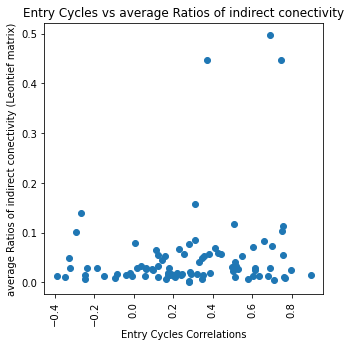
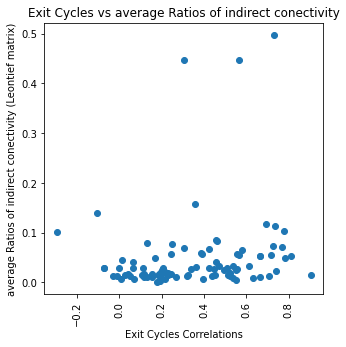
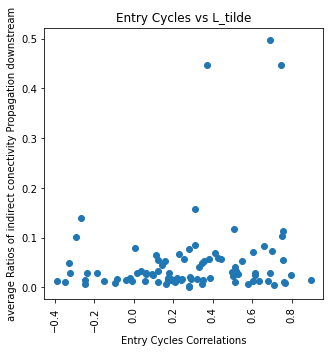
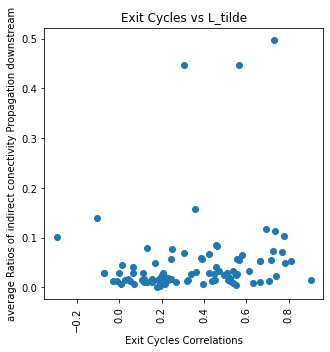

De nuevo, vemos una relacion constante para todos los casos.

# 2. Modelo multi-sectorial con sector transable

### NOTA IMPORTANTE: para resolver el modelo se uso el supuesto de $\epsilon_Q=\epsilon_M$

## 2.1

Las familias resuelven el siguiente problema:

$$ \max_{C_j} C=\prod_{j=1}^{N+1} C_j^{\beta_j}$$ 

$$ s.t: \sum_{j=1}^{N+1} P_jC_j\le W\overline{L}+\Pi+R\overline{K}-\overline{Y}$$

El lagrangeano se plantea como:

$$\mathcal{L}: \prod_{j=1}^{N+1} C_j^{\beta_j}+\lambda[W\overline{L}+\Pi+R\overline{K}-\overline{Y}-\sum_{j=1}^{N+1} P_jC_j]$$

Las CPO son:

$$\frac{\partial \mathcal{L} }{\partial C_1}= \beta_1C_1^{\beta_1-1}C_2^{\beta_2}\prod_{j=3}^{N+1} C_j-\lambda P_1=0$$
$$\frac{\partial \mathcal{L} }{\partial C_2}= \beta_1C_1^{\beta_1}C_2^{\beta_2-1}\prod_{j=3}^{N+1} C_j-\lambda P_1=0$$

Si despejamos $\lambda$ e igualamos obtenemos:

$$\frac{\beta_1}{C_1P_1}=\frac{\beta_2}{C_2 P_2}$$

Esto lo podemos generalizar a:

$$\frac{\beta_1}{C_1P_1}=\frac{\beta_2}{C_2 P_2}=...=\frac{\beta_j}{C_jP_j}=\frac{\beta_{N+1}}{C_{N+1}P_{N+1}}$$

Lo cual podemos expresar estas $N+1$ expresiones en funcion de $C_jP_j$:

$$C_1P_1=\frac{\beta_1C_jP_j}{\beta_j}$$   
$$C_2P_2=\frac{\beta_2C_jP_j}{\beta_j}$$   
$$...$$

$$C_{N+1}P_{N+1}=\frac{\beta_{N+1}C_jP_j}{\beta_j}$$

con estas expresiones las introducimos en $\sum_{j=1}^{N+1} P_jC_j$ desarrollada. Luego podemos factorizar y llegar a la siguiente expresion:

$$\sum_{j=1}^{N+1} P_j C_j=\frac{C_j P_j}{\beta_j}\sum_{j=1}^{N+1} \beta_j$$

Ademas, sabemos que $\sum_{j=1}^{N+1} \beta_j=1$. Por lo tanto, y gracias a la restriccion, podemos igualar la expresion encontrada con los ingresos de los hogares:

$$\frac{C_j P_j}{\beta_j}=W\overline{L}+\Pi+R\overline{K}-\overline{Y}$$

De ahi podemos despejar $C_j$ y obtener nuestra demanda de consumo por el bien $j$

$$C_j=\frac{\beta_j(W\overline{L}+\Pi+R\overline{K}-\overline{Y})}{P_j}$$

Al final podemos ver que la demanda de consumo $C_j$ depende de 3 elementos: La riqueza o nivel de ingresos de la persona $W\overline{L}+\Pi+R\overline{K}-\overline{Y}$; que tanto valora el bien de consumo subjetivamente $\beta_j$ y, por ultimo; del precio del bien $P_j$

## 2.2

Las firmas que no producen commodities tienen la siguiente funcion de produccion:

$$Q_j=z_j(a_j^{1-\rho_Q}L_j^{\rho_Q}+(1-a_j)^{1-\rho_Q}M_j^{\rho_Q})^{1/\rho_Q}$$

La firma maximiza la siguiente funcion de beneficios:

$$\Pi_j= P_jQ_j-W_jL_j-P_j^MM_j$$

Las CPO son:

$$\frac{\partial \Pi_j }{\partial L_j}= P_jz_j(a_j^{1-\rho_Q}L_j^{\rho_Q}+(1-a_j)^{1-\rho_Q}M_j^{\rho_Q})^{\frac{1-\rho_Q}{\rho_Q}}a_j^{1-\rho_Q}L_j^{\rho_Q-1}-W_j=0$$

Ahora, despejamos $W_j$ y ordenamos un poco la expresion para obtener:

$$W_j=P_ja_j^{1-\rho_Q}z_j^{\rho_Q}(\frac{Q_j}{L_J})^{1-\rho_Q}$$

$$\frac{\partial \Pi_j }{\partial M_j}= P_jz_j(a_j^{1-\rho_Q}L_j^{\rho_Q}+(1-a_j)^{1-\rho_Q}M_j^{\rho_Q})^{\frac{1-\rho_Q}{\rho_Q}}(1-a_j)^{1-\rho_Q}M_j^{\rho_Q-1}-P_j^M=0$$

De la misma forma, despejamos $P_J^M$ y ordenamos la expresion para obtener:

$$P_j^M=P_j(1-a_j)^{1-\rho_Q}z_j^{\rho_Q}(\frac{Q_j}{M_J})^{1-\rho_Q}$$

Por otro lado, tenemos la firma $N+1$ que produce commodities con la siguiente funcion de produccion:

$$Q_{N+1}=z_{N+1}(a_l^{1-\rho_Q}L_{N+1}^{\rho_Q}+a_m^{1-\rho_Q}M_{N+1}^{\rho_Q}+a_K^{1-\rho_Q}K_{{N+1}}^{\rho_Q})^{1/\rho_Q}$$

Cuya funcion de beneficios a maximizar es:

$$\Pi_{N+1}= P_{N+1}Q_{N+1}-W_{N+1}L_{N+1}-P_{N+1}^MM_{N+1}-RK_{N+1}$$

Las condiciones de primer orden son:

$$\frac{\partial \Pi_{N+1} }{\partial L_{N+1}}= P_{N+1}z_{N+1}(a_l^{1-\rho_Q}L_{N+1}^{\rho_Q}+a_m^{1-\rho_Q}M_{N+1}^{\rho_Q}+a_k^{1-\rho_Q}K_{{N+1}}^{\rho_Q})^{\frac{1-\rho_Q}{\rho_Q}}a_l^{1-\rho_Q}L_{N+1}^{\rho_Q-1}-W_{N+1}=0$$

$$\frac{\partial \Pi_{N+1} }{\partial M_{N+1}}= P_{N+1}z_{N+1}(a_l^{1-\rho_Q}L_{N+1}^{\rho_Q}+a_m^{1-\rho_Q}M_{N+1}^{\rho_Q}+a_k^{1-\rho_Q}K_{{N+1}}^{\rho_Q})^{\frac{1-\rho_Q}{\rho_Q}}a_m^{1-\rho_Q}M_{N+1}^{\rho_Q-1}-P_{N+1}^M=0$$

$$\frac{\partial \Pi_{N+1} }{\partial K_{N+1}}= P_{N+1}z_{N+1}(a_l^{1-\rho_Q}L_{N+1}^{\rho_Q}+a_m^{1-\rho_Q}M_{N+1}^{\rho_Q}+a_k^{1-\rho_Q}K_{{N+1}}^{\rho_Q})^{\frac{1-\rho_Q}{\rho_Q}}a_k^{1-\rho_Q}K_{N+1}^{\rho_Q-1}-K_{N+1}=0$$

Despejamos $W_{N+1}, P_{N+1}^M, K_{N+1}$ respectivamente de sus expresiones:

$$L_{N+1}=P_{N+1}a_l^{1-\rho_Q}z_{N+1}^{\rho_Q}(\frac{Q_{N+1}}{L_{N+1}})^{1-\rho_Q}$$

$$P_{N+1}^M=P_{N+1}a_m^{1-\rho_Q}z_{N+1}^{\rho_Q}(\frac{Q_{N+1}}{M_{N+1}})^{1-\rho_Q}$$

$$K_{N+1}=P_{N+1}a_k^{1-\rho_Q}z_{N+1}^{\rho_Q}(\frac{Q_{N+1}}{K_{N+1}})^{1-\rho_Q}$$  

## 2.3

Una vez decidido cuanto demandar de factores productivos optimamente (entre ellas la canasta de materiales $M_j$) las firmas deben decidir la composicion optima de su canasta $M_j$. Esto es, resolver el siguiente problena:

$$ \max_{M_{ji}} \sum_{i=1}^{N+1}(1+\chi_{ji})P_iM_{ji}$$

$$s.t: M_j=(\sum_{i=1}^{N+1} \omega_{ji}^{1-\rho_M}M_{ji}^{\rho_M})^{1/\rho_M}$$

El Lagrangeano para este problema queda de forma tal que:

$$\mathcal{L}:\sum_{i=1}^{N+1}(1+\chi_{ji})P_iM_{ji}+\lambda[ M_j-(\sum_{i=1}^{N+1} \omega_{ji}^{1-\rho_M}M_{ji}^{\rho_M})^{1/\rho_M}] $$

Las condiciones de primer orden son:

$$\frac{\partial \sum_{i=1}^{N+1}P_iM_{ji} }{\partial M_{ji}}= (1+\chi_{ji})P_i-\lambda(\sum_{i=1}^{N+1} \omega_{ji}^{1-\rho_M}M_{ji}^{\rho_M})^{\frac{1-\rho_M}{[\rho_M]}}\omega_{ji}^{1-\rho_M}M_{ji}^{\rho_M-1}=0$$

$$(1+\chi_{ji})P_i=\lambda(\frac{M_j\omega_{ji}}{M_{ji}})^{1-\rho_M}$$

Despejamos $M_{ji}$:

$$M_{ji}=\lambda^{\frac{1}{1-\rho_M}}M_j\omega_{ji}((1+\chi_{ji})P_i)^{\frac{1}{\rho_M-1}}$$

Sustituimos este valor en la agregacion de la canasta $M_j$:

$$ M_j=(\sum_{i=1}^{N+1} \omega_{ji}^{1-\rho_M}(\lambda^{\frac{1}{1-\rho_M}}M_j\omega_{ji}((1+\chi_{ji})P_i)^{\frac{1}{\rho_M-1}})^{\rho_M})^{1/\rho_M}$$

Ordenamos y despejamos $\lambda$:

$$\lambda=(\sum_{i=1}^{N+1} \omega_{ji}((1+\chi_{ji})P_i)^{\frac{rho_M}{\rho_M-1}})^{\frac{\rho_M-1}{\rho_M}}$$

Ahora, podemos sustituir las siguientes expresiones:

$$\lambda=P_j^M$$

$$\rho_M=\frac{\epsilon_M-1}{\epsilon_M}$$

Por lo tanto, obtenemos:

$$P_j^M=(\sum_{i=1}^{N+1} \omega_{ji}((1+\chi_{ji})P_i)^{1-\epsilon_M})^{\frac{1}{1-\epsilon_M}}$$

Si no hubieran distorsiones $1+\chi_{ji}=0$, entonces: 

$$P_j^M=(\sum_{i=1}^{N+1} \omega_{ji}(P_i)^{1-\epsilon_M})^{\frac{1}{1-\epsilon_M}}$$

Esto implica que el efecto de las distorsiones en los precios de los bienes intermedios provoca un alza en el precio de la canasta de estos mismo bienes compesado por la elasticidad y la relevancia que tenga ese material en la produccion de la firma.

## 2.4

Ahora reescribimos la funcion de produccion $Q_j$ de forma tal de generar los ratios $L_j/Q_j$ y $M_j/Q_j$:

$$Q_j/Q_j=z_j(a_j^{1-\rho_Q}(L_j/Q_j)^{\rho_Q}+(1-a_j)^{1-\rho_Q}(M_j/Q_j)^{\rho_Q})^{1/\rho_Q}$$

De las condiciones de primer orden de la firma $j$ sabemos que:

$$W_j=P_ja_j^{1-\rho_Q}z_j^{\rho_Q}(\frac{Q_j}{L_J})^{1-\rho_Q}$$

$$P_j^M=P_j(1-a_j)^{1-\rho_Q}z_j^{\rho_Q}(\frac{Q_j}{M_J})^{1-\rho_Q}$$

Si despejamos $L_j/Q_j$ y $M_j/Q_j$ de las ecuaciones respectivas, obtenemos:

$$L_j/Q_j=(\frac{W_j}{P_ja_j^{1-\rho_Q}z^{\rho_Q}})^{\frac{1}{\rho_Q-1}}$$  

y

$$M_j/Q_j=(\frac{P_j^M}{P_j(1-a_j)^{1-\rho_Q}z^{\rho_Q}})^{\frac{1}{\rho_Q-1}}$$

que ahora podemos introducir en la expresion deseada:

$$1=z_j(a_j^{1-\rho_Q}((\frac{W_j}{P_ja_j^{1-\rho_Q}z^{\rho_Q}})^{\frac{1}{\rho_Q-1}})^{\rho_Q}+(1-a_j)^{1-\rho_Q}((\frac{P_j^M}{P_j(1-a_j)^{1-\rho_Q}z^{\rho_Q}})^{\frac{1}{\rho_Q-1}})^{\rho_Q})^{1/\rho_Q}$$

Tomamos $W_j$ como el numerario de esta economia, por lo tanto luego de simplificar y despejar $P_j$ tenemos:

$$P_j^{\frac{\rho_Q}{\rho_Q-1}}=z_j^{\frac{\rho_Q}{1-\rho_Q}}(a_j+(1-a_j)(P_j^{M})^{{\frac{\rho_Q}{\rho_Q-1}}})$$

Hacemos la siguiente sustitucion: $\rho_Q=\frac{\epsilon_Q-1}{\epsilon_Q}$. Quedando asi la siguiente expresion para los precios:

$$P_j^{1-\epsilon_Q}=z_j^{\epsilon_Q-1}(a_j+(1-a_j)(P_j^{M})^{1-\epsilon_Q})$$

Matricialmente se puede representar esto como un sistema de ecuaciones de $N$ incognitas

$$P^{1-\epsilon_Q}=z^{1-\epsilon_Q}*a+z^{1-\epsilon_Q}*(1-a)*[\Omega P^{1-\epsilon_Q}]$$

NOTA: $*$ significa multiplicacion de elementos de la matriz por los mismos elementos de la otra matriz

donde $P^{1-\epsilon_Q}$ es el vector:

$$P_{j}^{1-\epsilon_Q}=\begin{bmatrix}
P_{1}^{1-\epsilon_Q} \\
P_{2}^{1-\epsilon_Q}\\
\vdots  \\
P_{N}^{{1-\epsilon_Q}}
\end{bmatrix}$$

el vector $a$ es:

$$a_{j}=\begin{bmatrix}
a_{1} \\
a_{2}\\
\vdots  \\
a_{N}
\end{bmatrix}$$

el vector $z$ es:

$$z_{j}^{1-\epsilon_Q}=\begin{bmatrix}
z_{1}^{1-\epsilon_Q} \\
z_{2}^{1-\epsilon_Q}\\
\vdots  \\
z_{N}^{{1-\epsilon_Q}}
\end{bmatrix}$$

Y la matriz $\Omega$ es:

$$\begin{bmatrix}
\omega_{11} & \cdots & \omega_{1N} \\
\vdots & \ddots & \vdots  \\
\omega_{N1} & \cdots &\omega_{NN}
\end{bmatrix}$$

La solucion matricial de los precios es:

$$P^{1-\epsilon_Q}= (I-z^{1-\epsilon_Q}*(1-a)\Omega)^{-1}z^{1-\epsilon_Q}*a$$

## 2.5

Sabemos que la condicion de primer orden de $L_j$ se puede escribir:

$$L_j/Q_j=(\frac{W_j}{P_ja_j^{1-\rho_Q}z^{\rho_Q}})^{\frac{1}{\rho_Q-1}}$$  

Mientras que la condicion de primer orden de $M_j$ se escribe como:

$$M_j/Q_j=(\frac{P_j^M}{P_j(1-a_j)^{1-\rho_Q}z^{\rho_Q}})^{\frac{1}{\rho_Q-1}}$$

El cociente de estas 2 expresiones y sustituyendo el salario por su respectivo numerario, obtenemos:

$$L_j=(P_j^M)^{\epsilon_Q} \frac{a_jM_j}{(1-a_j)} $$

Por otro lado, la condicion de primer orden de $M_j$ se ve asi:

$$P_j^M=P_j(1-a_j)^{1-\rho_Q}z_j^{\rho_Q}(\frac{Q_j}{M_J})^{1-\rho_Q}$$

Podemos despejar $M_j$:

$$M_j=(P_j/P_J^M(1-a_j)^{1-\rho_Q}z_j^{\rho_Q}Q_j^{1-\rho_Q})^{^{\frac{1}{1-\rho_Q}}}$$

Reemplazamos este valor en nuestra expresion para el trabajo:

$$L_j=(P_j^M)^{\epsilon_Q} \frac{a_j((P_j/P_J^M(1-a_j)^{1-\rho_Q}z_j^{\rho_Q}Q_j^{1-\rho_Q})^{^{\frac{1}{1-\rho_Q}}})}{(1-a_j)} $$

simplificando y reemplazando $\rho_Q$ obtenemos lo siguiente:

$$L_j=a_jz_j^{\epsilon_Q-1}P_j^{\epsilon_Q-1}s_j(1+R\overline{K}+\Pi-\overline{Y})$$

donde $P_cC=1+R\overline{K}+\Pi-\overline{Y}$ y $s_j=\frac{P_jQ_j}{P_cC}$  

Aplicamos Sumatoria a ambos lados de la igualdad:

$$\sum_{j=1}^{N+1}L_j= \sum_{j=1}^{N+1}a_jz_j^{\epsilon_Q-1}P_j^{\epsilon_Q-1}s_j(1+R\overline{K}+\Pi-\overline{Y})$$

Y debido a que el trabajo es inelastico, las condiciones de vaciado de mercado nos dan que:

$$\overline{L}=\sum_{j=1}^{N+1}L_j=1$$

Por lo tanto,

$$1=(1+R\overline{K}+\Pi-\overline{Y}) \sum_{j=1}^{N+1}a_jz_j^{\epsilon_Q-1}P_j^{\epsilon_Q-1}s_j$$

$$(1+R\overline{K}+\Pi-\overline{Y})=\frac{1}{\sum_{j=1}^{N+1}a_jz_j^{\epsilon_Q-1}P_j^{\epsilon_Q-1}s_j}$$

Acabamos de tener una expresion de los ingresos de los hogares.

A partir de esta expresion podemos resolver el consumo de los hogares $C_j$:

La condicion de primer orden de los hogares es tal que:

$$C_j=\frac{\beta_j(W\overline{L}+\Pi+R\overline{K}-\overline{Y})}{P_j}$$

Reemplazamos el ingreso nominal y obtenemos:

$$C_j=\frac{\beta_j}{P_j\sum_{j=1}^{N+1}a_jz_j^{\epsilon_Q-1}P_j^{\epsilon_Q-1}s_j }$$

Matricialmente el problema se ve como:

$$ C= \frac{\beta}{P[(P^{\epsilon_Q-1})^T(a*z^{\epsilon_Q-1}*s)]}$$

donde el vector $C$ se ve:

$$C_{j}=\begin{bmatrix}
C_{1} \\
C_{2}\\
\vdots  \\
C_{N+1}
\end{bmatrix}$$

donde el vector $s$ se ve:

$$s_{j}=\begin{bmatrix}
s_{1} \\
s_{2}\\
\vdots  \\
s_{N+1}
\end{bmatrix}$$

donde el vector $\beta$ se ve:

$$\beta_{j}=\begin{bmatrix}
\beta_{1} \\
\beta_{2}\\
\vdots  \\
\beta_{N+1}
\end{bmatrix}$$

## 2.6

Por ultimo, nos queda resolver $Q_j$. Sabemos que las condiciones de vaciado de mercado son:

$$Q_j=C_j+C_j^*+\sum_{i=1}^{N+1}M_{ij}$$

para resolver el problema, es necesario encontrar una expresion para $M_{ij}$

de las condiciones de optimalidad, habiamos encontrado que:

$$M_{ji}= ((1+\chi_{ji})\frac{P_i}{P_j^M})^{-\epsilon_Q}M_j\omega_{ji} $$

y para $M_j$ habiamnos encontrado que:

$$M_j=((1-a_j)\frac{P_j}{P_j^M})^{\epsilon_Q}z_j^{\epsilon_Q-1}Q_j $$

Sustituimos la expresion y obtenemos:

$$M_{ji}= ((1+\chi_{ji})\frac{P_i}{P_j^M})^{-\epsilon_Q}((1-a_j)\frac{P_j}{P_j^M})^{\epsilon_Q}z_j^{\epsilon_Q-1}Q_j \omega_{ij} $$

simplificando y teniendo en cuenta que ante elasticidades homogeneas $P_j=P_i$

$$M_{ji}= (1+\chi_{ji})^{-\epsilon_Q}(1-a_j)^{\epsilon_Q}z_j^{\epsilon_Q-1}Q_j \omega_{ij} $$

Ahora, con esta expresion la sustituimos en nuestra condicion de vaciado de mercado:

$$Q_j=C_j+C_j^*+(1-a_j)^{\epsilon_Q}z_j^{\epsilon_Q-1}Q_j\sum_{i=1}^{N+1}(1+\chi_{ji})^{-\epsilon_Q} \omega_{ij}$$

Despejamos $Q_j$:

$$Q_j=\frac{C_j+C_j^*}{1-(1-a_j)^{\epsilon_Q}z_j^{\epsilon_Q-1}\sum_{i=1}^{N+1}(1+\chi_{ji})^{-\epsilon_Q} \omega_{ij}}$$

Matricialmente podemos plantear el sistema de ecuaciones $N+1$ para $Q_j$ asi:

$$Q=(C+C^*)*\frac{1}{I-(1-a)^{\epsilon_Q}z^{\epsilon_Q-1}[(1+\chi)\Omega1]}$$

donde el vector $C^*$ se ve:

$$C^*_{j}=\begin{bmatrix}
C^*_{1} \\
C^*_{2}\\
\vdots  \\
C^*_{N+1}
\end{bmatrix}$$

Y la matriz distorsiones $1+\chi$ es:

$$\begin{bmatrix}
1 & \cdots & 1 \\
\vdots & \ddots & \vdots  \\
1 & \cdots &1
\end{bmatrix} +\begin{bmatrix}
\omega_{11} & \cdots & \omega_{1N} \\
\vdots & \ddots & \vdots  \\
    \omega_{N1} & \cdots &\omega_{NN}
\end{bmatrix}$$

y  el vector $(N+1)x1$ de $1$ es:

$$1=\begin{bmatrix}
1 \\
1\\
\vdots  \\
1
\end{bmatrix}$$

Asi, de esta forma podemos calcular la produccion $Q_j$ de cada sector de la economia.



## 3. Calibración y simulaciones


A continuacion presentamos el sistema a resolver:

$$
P_j^{1-\epsilon_Q}=Z_j^{\epsilon_Q-1}\left(a_j+\left(1-a_j\right)\left(P_j^M\right)^{1-\epsilon_Q}\right)
$$

Donde $P_j^M$ es:

$$P_j^M=(\sum_{i=1}^{N+1} \omega_{ji}((1+\chi_{ji})P_i)^{1-\epsilon_M})^{\frac{1}{1-\epsilon_M}}$$

Sustituimos y obtenemos la expresion para precios:

$$
P_j^{1-\epsilon_Q}=Z_j^{\epsilon_Q-1}a_j+Z_j^{\epsilon_Q-1}(1-a_j)(\sum_{i=1}^{N+1} \omega_{ji}((1+\chi_{ji})P_i)^{1-\epsilon_M})
$$

Que matricialmente puede ser escrito como:

$$
P^{1-\epsilon_Q}=a \circ Z^{\epsilon_Q-1}+((1-a) \circ Z^{\epsilon_Q-1}) \circ [(\Omega\circ (1+\chi)^{1-\epsilon_Q})(P^\prime)^{1-\epsilon_Q}]
$$

Una expresion para el consumo es:

$$P_jC_j=\beta_jP_CC $$

donde $P_CC$ es la canasta de consumo.

Por lo tanto, podemos despejar el consumo y tener:

$$C_j=\frac{\beta_jP_CC}{P_j} $$


Una vez los precios y consumo listos, ahora podemos resolver para cantidades $Q$. Para esto tenemos lo siguiente:

$$Q_j=C_j+C_j^*+\sum_{i=1}^{N+1} M_{i j}$$
$$M_j=((1-a_j) \frac{P_j}{P_j^M})^{\epsilon_Q} Z_j^{\epsilon_Q-1} Q_j$$
$$M_{j i}=((1+\chi_{j i}) \frac{P_i}{P_j^M})^{\epsilon_Q} M_j \omega_{j i}$$

Introducimos la segunda ecuacion en la primera y obtenemos:

$$M_{j i}=((1+\chi_{j i}) {P_i})^{-\epsilon_Q} ((1-a_j) {P_j})^{\epsilon_Q} Z_j^{\epsilon_Q-1} Q_j \omega_{j i}$$

Ahora, podemos introducir esta expresion en la primera y asi tenemos:

$$Q_j=C_j+C_j^*+((1-a_j) {P_j})^{\epsilon_Q}Z_j^{\epsilon_Q-1} Q_j\sum_{i=1}^{N+1} ((1+\chi_{j i}) {P_i})^{-\epsilon_Q}   \omega_{j i}$$

Expresado en forma matricial queda:

$$Q=C+C^*+((1-a) \circ {P})^{\epsilon_Q} \circ Z^{\epsilon_Q-1} \circ Q [ ((1+\chi)^{-\epsilon_Q}\circ \Omega) ({P}^\prime)^{-\epsilon_Q}$$

Solo falta resolver de forma endogena el consumo que depende las ventas. Para ello tenemos la siguiente expresion:

$$
1+\Pi+R \bar{K}-\bar{Y}=\frac{1}{\sum_{j=1}^{N+1} a_j Z_j^{\epsilon_Q-1} P_j^{\epsilon_Q-1} s_j}
$$

donde $s_j= \frac{P_jQ_j}{P_CC}$ . Sabiendo que:

$$C_j= \frac{\beta_j(1+\Pi+R \bar{K}-\bar{Y})}{P_j} $$

Podemos escribir $C_j$ como:

$$C_j= \frac{\beta_j}{P_j\sum_{j=1}^{N+1} a_j Z_j^{\epsilon_Q-1} P_j^{\epsilon_Q-1} s_j} $$

Cuya forma matricial es:

$$C_j= \beta (a \circ Z^{\epsilon_Q-1} \circ (P^{\epsilon_Q} s))^{-1}$$

donde $P^{1-\epsilon_Q}$ es el vector:

$$P_{j}^{1-\epsilon_Q}=\begin{bmatrix}
P_{1}^{1-\epsilon_Q} \\
P_{2}^{1-\epsilon_Q}\\
\vdots  \\
P_{N}^{{1-\epsilon_Q}}
\end{bmatrix}$$

el vector $a$ es:

$$a_{j}=\begin{bmatrix}
a_{1} \\
a_{2}\\
\vdots  \\
a_{N}
\end{bmatrix}$$

el vector $z$ es:

$$z_{j}^{1-\epsilon_Q}=\begin{bmatrix}
z_{1}^{1-\epsilon_Q} \\
z_{2}^{1-\epsilon_Q}\\
\vdots  \\
z_{N}^{{1-\epsilon_Q}}
\end{bmatrix}$$

Y la matriz $\Omega$ es:

$$\begin{bmatrix}
\omega_{11} & \cdots & \omega_{1N} \\
\vdots & \ddots & \vdots  \\
\omega_{N1} & \cdots &\omega_{NN}
\end{bmatrix}$$

donde el vector $C$ se ve:

$$C_{j}=\begin{bmatrix}
C_{1} \\
C_{2}\\
\vdots  \\
C_{N+1}
\end{bmatrix}$$

donde el vector $s$ se ve:

$$s_{j}=\begin{bmatrix}
s_{1} \\
s_{2}\\
\vdots  \\
s_{N+1}
\end{bmatrix}$$

donde el vector $\beta$ se ve:

$$\beta_{j}=\begin{bmatrix}
\beta_{1} \\
\beta_{2}\\
\vdots  \\
\beta_{N+1}
\end{bmatrix}$$

donde el vector $C^*$ se ve:

$$C^*_{j}=\begin{bmatrix}
C^*_{1} \\
C^*_{2}\\
\vdots  \\
C^*_{N+1}
\end{bmatrix}$$

Y la matriz distorsiones $1+\chi$ es:

$$\begin{bmatrix}
1 & \cdots & 1 \\
\vdots & \ddots & \vdots  \\
1 & \cdots &1
\end{bmatrix} +\begin{bmatrix}
\omega_{11} & \cdots & \omega_{1N} \\
\vdots & \ddots & \vdots  \\
    \omega_{N1} & \cdots &\omega_{NN}
\end{bmatrix}$$


## 3.1

- En primer lugar vamos a calibrar la matriz $\Omega$ compuesta de los elementos $\omega_{ji}$. Para ello, se utilizara la base de datos de la BEA que provee la matriz de insumos productos de la economia estadounidense en 1997. Especificamente prestaremos atencion a la fila "Total Intermediate". La definicion vista en clases de $\omega{ji}$ es de la importancia que tiene una industria $j$ proveyendo insumos a otra industria $i$ o mejor dicho la production network. A partir de esta idea, calcularemos los elementos de la matriz $\Omega$ como:

$$\Omega=\omega_{ji}= \frac{P_iM_{ji}}{Total Intermediate_j}$$

- A continuacion calibraremos el vector $\beta_j$. Este parametro se entiende como la importancia o valoracion subjetiva que tienen los hogares por bienes. Es decir, la ponderacion que se le va a dar a cada bien dentro de la canasta de consumo. Para calibrar dicho vector, de nuevo utilizaremos la matriz de insumos productos de la BEA. En especial, prestaremos atencion a la siguiente fila: "Personal consumption expenditures". Esta fila reporta el consumo de los privados por los bienes producidos por cada sector. El vector $\beta_j$ se calcula como como:

$$\beta_j= \frac{P_jC_j}{P_cC} $$

- Ahora es el turno de calibrar el vector $a_j$. Esta mide la importancia relativa de los factores productivos a la hora de producir en una firma.Este puede ser encontrado a traves de las condiciones de primer orden de las firmas:

$$W_j=P_ja_j^{1/\epsilon_Q}z_j^{\frac{\epsilon_Q-1}{\epsilon_Q}}(\frac{Q_j}{L_j})^{1/\epsilon_Q}$$

Podemos despejar de esta expresion $a_j$:

$$a_j=\frac{W_j^{\epsilon_Q}L_j}{P_j^{\epsilon_Q}Q_j}$$ 

A partir de aca tenemos que hacer una suposicion importante:

$$\epsilon_Q=1$$

Mas abajo explicaremos esta calibracion. Por lo tanto, la expresion nos queda a:

$$a_j=\frac{W_jL_j}{P_jQ_j}$$ 

Esta informacion puede ser conseguida facilmente con la BEA. Tenemos que prestar atencion a la base de datos, en especial, las columnas "Total industry output (basic prices)" y "Compensation of employees" Donde cada columna nos da los elementos necesarios para construir el vector $a_j$

- Es turno de hablar sobre la elasticidades de sustitucion $\epsilon_Q$ y $\epsilon_M$. En primer lugar se va a seguir manteniendo el supuesto de $\epsilon_Q = \epsilon_M$. Por lo tanto, en el modelo se hara referecia siempre a $\epsilon_Q$. De acuerdo a las estimaciones hechas por Miranda-Pinto, $\epsilon_Q= 2.52$ (Miranda-Pinto, 2021)


- Se va a trabajar en torno al estado estacionario, por lo tanto el vector $z$ sera un vector de unos.

- Tambien necesitamos calibrar las ventas o sales para poder resolver el consumo. Sin embargo, este supone un problema por lo siguiente. $s_j$ se puede calcular como:

$$s_j= \frac{P_jQ_j}{P_cC} $$

Mientras que $P_cC$ se calcula como:

$$ P_cC= \frac{P_jC_j}{\beta_j}$$

Si sustituimos nos quedaria algo como:

$$ s_j= \frac{\beta_jQ_j}{C_j} $$ 

Esto supone un problema ya que vuelve el sistema lineal a algo no lineal. Por lo tanto, se va a calcular con la BEA utilizando la fila "Personal consumption expenditures" y "Total industry output (basic prices)". Asi $s_j$ que es endogeno lo volvemos algo exogeno. El problema es que ante un shock cualquiera, esta variable no se ajustara. La interpretacion de este fenomeno se puede enteder como: ante un shock cualquiera, por ejemplo precios, la canasta de consumo se mantendra fija, es decir los individuos compraran el valor de la canasta siempre, ahora la composicion de esta si cambiara. 

- Por ultimo, solo queda calibrar el vector $C_j^*$. Este se entiende como las exportaciones. En esta economia, el sector $N+1$ es el unico que exporta commodities. Por lo tanto podemos expresar el vector de la siguiente forma:

$$C^*_{j}=\begin{bmatrix}
0 \\
0\\
\vdots  \\
C^*_{N+1}
\end{bmatrix}$$

#### NOTA IMPORTANTE:

El vector $P^{1-\epsilon_Q}$ es de $Nx1$. Tenemos que agregar una ultima fila $P_{N+1}$ cuya funcion sera ver el precio del commoditie que se exporta. El sector escogido para ser el exportador de commodities sera Mining. La posicion de Mining en las matrices de la BEA no necesariamente es la ultima, en realidad es la 2 industria que aparece. Por lo tanto cuando se hable del sector exportador $N+1$ en realidad se hablara del segundo elemento de la matriz/vector. Se trabajara con el vector precios $P^{1-\epsilon_Q}$ de tamaño $N+1xN+1$ con esta consideracion.

Por ultimo, se tomo la decision de sacar ciertos sectores de las simulaciones. El problema es que estos sectores aparecen en la BEA con 0 consumo. Debido a las caracteristicas de nuestra modelo y el hecho de que justamente esas empresas no son las que exportaran, se decidio sacarlas. Los sectores fuera son: Construction y Wholesale Trade. Por lo tanto, quedan 13 sectores, de los cuales, mining es el sector exportador de commodities.

Los principales compradores del sector Mining de acuerdo a la matriz de Leontief son:

| Commodities/Industries                               |   Mining |
|:-----------------------------------------------------|---------:|
| Mining                                               | 1.08969  |
| Manufacturing                                        | 0.870326 |
| Utilities                                            | 0.18927  |
| Government                                           | 0.103382 |
| Finance, insurance, real estate, rental, and leasing | 0.038598 |

Los principales vendedores al sector Mining de acuerdo a la matriz de Leontief son:

| Commodities/Industries                               |     Mining |
|:-----------------------------------------------------|-----------:|
| Mining                                               | 1.08969    |
| Utilities                                            | 0.0133406  |
| Finance, insurance, real estate, rental, and leasing | 0.0118063  |
| Professional and business services                   | 0.00912485 |
| Manufacturing                                        | 0.00665345 |

## 3.2

Ver Anexo para ver resultados

## 3.3

Vemos que cuando se duplica el precio  del bien domestico, el consumo aumenta para todos los bienes menos del que se duplico el precio (se mantiene igual). La produccion cae para todos los sectores pero considerablemente muy poco. En terminos agregados, los ingresos de los hogares aumentan, tambien aumenta el GDP y el consumo agregado.

## 3.4

Ahora se resolvera el modelo con distorsiones downstream. En este caso, cuando el precio del sector commodity se duplica, vemos que el consumo aumenta (no muy considerablemente), la produccion decae tambien muy poco. En terminos agregados, los ingresos del hogar crecen, pero apenas una fraccion muy pequeña (7 veces menos que el caso sin distorsiones). El GDP sube casi 6 veces menos que el caso sin distorsiones. El consumo agregado sube pero igual menos que el caso sin distorsiones.

Si se permiten distorsiones upstream, tenemos los siguientes efectos al duplicar el precio del sector commodity: El consumo sube, la produccion cae ambos de forma no tan fuerte. El ingreso del hogar sube pero apenas 1/3 aproximadamente del caso sin distorsiones. El GDP tambien sube, pero este solo sube tambien un 1/3 aproximadamente de lo que sube en el caso sin distorsiones. El consumo agregado sube, pero este apenas es la mitad de lo que hubiera subido en el caso sin distorsiones.

A continuacion, vamos a comparar los efectos de un shock con distorsiones upstream con uno downstream. Al duplicar los precios, vemos que en el caso downstream este sube menos que el upstream. El consumo domestico de todos los sectores aumenta mas cuando hay un shock en esta economia upstream. La produccion cae menos cuando hay un shock en una economia upstream. En terminos agregados, los ingresos nominales aumentan mas cuando hay un shock con distorsiones upstream que downstream. El GDP, al igual aumenta en el caso del upstream. EL consumo agregado sube mas tambien.

La explicacion de esto puede darse debido a que el sector mining es un sector que predominantemente es mas proveedor que comprador. Por lo tanto, cuando tiene algun tipo de distorsion con sus compradores, esto le afecta mas a la economia que en el caso cuando tiene distorsiones con sus proveedores el sector mining.

Para mayor detalle, consultar el Anexo

## Bibliografia

- Miranda-Pinto, Jorge, and Eric R. Young. 2022. "Flexibility and Frictions in Multisector Models." American Economic Journal: Macroeconomics, 14 (3): 450-80.
- Jorge Miranda Pinto, 2021. "Production Network Structure, Service Share, and Aggregate Volatility," Review of Economic Dynamics, Elsevier for the Society for Economic Dynamics, vol. 39, pages 146-173, January. <https://ideas.repec.org/a/red/issued/19-157.html>


## 3.1

In [13]:
df_BEA= pd.read_excel("Table.xlsx", header=4) #Importing Bureau of Economic Analysis (BEA)

#Cleaning and filtering the data from BEA


df_BEA.drop(df_BEA.columns[0], axis=1)
df_BEA.columns = df_BEA.iloc[1]
df_BEA.drop(1, inplace=True)
df_BEA.drop(df_BEA.columns[0],axis=1,inplace=True)
df_BEA.rename(columns={"Name":"Commodities/Industries"}, inplace=True)
df_BEA.drop(0, inplace=True)
df_BEA.set_index("Commodities/Industries", inplace=True)
df_BEA=df_BEA.replace("---", 0)
df_BEA=df_BEA.T
df_BEA.drop(["Scrap, used and secondhand goods","Noncomparable imports and rest-of-the-world adjustment"],
            axis=1, inplace=True)
df_BEA.index=df_BEA.index.rename(None)

#Droping Construction and Wholesale trade sectors

df_BEA=df_BEA.drop(columns=["Construction", "Wholesale trade"], index=["Construction", "Wholesale trade"])

#Creating the Ratios of expenditures γ, Γ Matrix

ratios_expenditures=np.zeros((df_BEA.index.get_loc("Total Intermediate"),df_BEA.columns.get_loc("Total Intermediate")))
for col in range (df_BEA.columns.get_loc("Total Intermediate")):
    for row in range (df_BEA.index.get_loc("Total Intermediate")):
        if col==row:
            ratios_expenditures[row,col]= (df_BEA.iloc[row,col]/
                                           df_BEA.iloc[df_BEA.index.get_loc("Total use of products"),col])
        if col<row:
            ratios_expenditures[row,col]=(df_BEA.iloc[row,col]/
                                          df_BEA.iloc[df_BEA.index.get_loc("Total use of products"),col])
        if col>row:
            ratios_expenditures[row,col]=(df_BEA.iloc[row,col]/
                                          df_BEA.iloc[df_BEA.index.get_loc("Total use of products"),col])
df_ratios_expenditures=(
    pd.DataFrame(ratios_expenditures, columns= (df_BEA.columns[:df_BEA.columns.get_loc("Total Intermediate")])))
df_ratios_expenditures=(
    df_ratios_expenditures.
    apply(lambda x: round(x, 4)).set_index(df_BEA.index[:df_BEA.index.get_loc("Total Intermediate")]))

#Calculating Leontief Matrix L

Leontief= (np.identity(df_ratios_expenditures.to_numpy().shape[0])-df_ratios_expenditures.to_numpy())
df_Leontief=(
    pd.DataFrame(np.linalg.inv(Leontief),index=df_ratios_expenditures.index, columns=df_ratios_expenditures.columns))

#Calculating the average indirects conectivity in Leontief

average_Leontief=np.zeros(df_Leontief.shape)
for col in range (df_Leontief.shape[1]):
    for row in range (df_Leontief.shape[0]):
        if col==row:
            average_Leontief[row,col]= None
        if col<row:
            average_Leontief[row,col]= (df_Leontief.iloc[row,col]+df_Leontief.iloc[col,row])/2
        if col>row:
            average_Leontief[row,col]=None

df_average_Leontief= pd.DataFrame(average_Leontief, columns= df_Leontief.columns)
df_average_Leontief= df_average_Leontief.apply(lambda x: round(x, 4)).set_index(df_Leontief.index)


#Calibrations:



#Calibrating Ω as a matrix of ω_ji
Ω=(np.zeros((df_BEA.index.get_loc("Total Intermediate"),
            df_BEA.columns.get_loc("Total Intermediate"))))
for col in range (df_BEA.columns.get_loc("Total Intermediate")):
    for row in range (df_BEA.index.get_loc("Total Intermediate")):
        if col==row:
            Ω[row,col]=(df_BEA.iloc[row,col]/
                        df_BEA.iloc[df_BEA.index.get_loc("Total Intermediate"),col])
        if col<row:
            Ω[row,col]=(df_BEA.iloc[row,col]/
                        df_BEA.iloc[df_BEA.index.get_loc("Total Intermediate"),col])
        if col>row:
            Ω[row,col]=(df_BEA.iloc[row,col]/
                        df_BEA.iloc[df_BEA.index.get_loc("Total Intermediate"),col])

#Calibrating β_j 
β_j=np.zeros((df_BEA.index.get_loc("Total Intermediate"),1))
for i in range (df_BEA.columns.get_loc("Total Intermediate")):
    β_j[i,0]= (df_BEA.iloc[df_BEA.index.get_loc("Personal consumption expenditures"), i]/
                 df_BEA.iloc[df_BEA.index.get_loc("Personal consumption expenditures"),
                             df_BEA.columns.get_loc("Total Intermediate")])
#Calibrating a_j
a_j=np.zeros((df_BEA.index.get_loc("Total Intermediate"),1))
for i in range (df_BEA.columns.get_loc("Total Intermediate")):
    a_j[i,0]= (df_BEA.iloc[i,df_BEA.columns.get_loc("Compensation of employees")]/
                 df_BEA.iloc[i, df_BEA.columns.get_loc("Total industry output (basic prices)")])
    
#Calibrating ϵ_Q
ϵ_Q= 2.52 
    
#calibrating z_j

z_j=np.ones((df_BEA.index.get_loc("Total Intermediate"),1))

#Calibrating Consumption basket PcC

PcC= df_BEA.loc["Personal consumption expenditures", "Total Intermediate"]
    
# Calibrating Exports: C*_N+1

cstar= np.zeros((13,1))
cstar[1]=1

print(df_Leontief[["Mining"]].nlargest(n=5, columns=["Mining"]).to_markdown()) #Top 5 buyers of Mining

print((df_Leontief.loc["Mining"].nlargest(n=5)).to_markdown()) #Top 5 suppliers of Mining

|                                                      |   Mining |
|:-----------------------------------------------------|---------:|
| Mining                                               | 1.08969  |
| Manufacturing                                        | 0.870326 |
| Utilities                                            | 0.18927  |
| Government                                           | 0.103382 |
| Finance, insurance, real estate, rental, and leasing | 0.038598 |
| Commodities/Industries                               |     Mining |
|:-----------------------------------------------------|-----------:|
| Mining                                               | 1.08969    |
| Utilities                                            | 0.0133406  |
| Finance, insurance, real estate, rental, and leasing | 0.0118063  |
| Professional and business services                   | 0.00912485 |
| Manufacturing                                        | 0.00665345 |


C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


## 3.2

In [14]:
#Building a solver so we can solve all the system of equations.


def solver(χ, downstream, shocks):
    
    if χ==0:
        
        χ_ji= np.ones((13,13)) + np.zeros((13,13))
        
    elif χ==1:
        
        if downstream==1:
        
            χ_ji=np.zeros((13,13))

            χ_ji[df_Leontief.index.get_loc("Manufacturing"),df_Leontief.columns.get_loc("Mining")]=1
            χ_ji[df_Leontief.index.get_loc("Utilities"),df_Leontief.columns.get_loc("Mining")]=1
            χ_ji[df_Leontief.index.get_loc("Government"),df_Leontief.columns.get_loc("Mining")]=1
            χ_ji[df_Leontief.index.get_loc("Mining"),df_Leontief.columns.get_loc("Mining")]=1
            χ_ji[df_Leontief.index.get_loc("Finance, insurance, real estate, rental, and leasing"),
                 df_Leontief.columns.get_loc("Mining")]=1

            χ_ji= np.ones((13,13))+χ_ji
            
        elif downstream==0:
            
            χ_ji=np.zeros((13,13))

            χ_ji[df_Leontief.index.get_loc("Mining"), df_Leontief.columns.get_loc("Manufacturing")]=1
            χ_ji[df_Leontief.index.get_loc("Mining"),df_Leontief.columns.get_loc("Utilities"),]=1
            χ_ji[df_Leontief.index.get_loc("Mining"),df_Leontief.columns.get_loc("Finance, insurance, real estate, rental, and leasing")]=1
            χ_ji[df_Leontief.index.get_loc("Mining"),df_Leontief.columns.get_loc("Mining")]=1
            χ_ji[df_Leontief.index.get_loc("Mining"),df_Leontief.columns.get_loc("Professional and business services") ]=1

            χ_ji= np.ones((13,13))+χ_ji
            
    shock=np.ones((13,1))
    shock[1]= shocks
    
    #Prices: 
    
    A= np.identity(13) - (1 - a_j) * z_j**(1-ϵ_Q) * Ω * χ_ji
    
    B= z_j**(1-ϵ_Q) * a_j
    
    P_j= np.linalg.solve(A, B)**(1/(1-ϵ_Q)) * shock

    #Q
    
    A= np.ones((13,1)) - ((1-a_j)**ϵ_Q * z_j**(ϵ_Q-1) * P_j**ϵ_Q * (Ω) * χ_ji**(-ϵ_Q)) @ (P_j**(-ϵ_Q))
    
    B= β_j * PcC / P_j + cstar

    Q_j= B/A
    
    #Consumption:
    
    C_j= β_j / (a_j * z_j**(ϵ_Q-1) * (np.transpose(P_j**(ϵ_Q-1)) @ (P_j * Q_j / PcC)))
    
    #House income:

    house_income=  np.sum(C_j * P_j / β_j)
    
    #exports:

    exports= np.sum(cstar*P_j)

    #Domestic GDP:

    GDP= house_income + exports

    #Aggregate Consumption

    Aggregate_Consumption= np.sum(β_j*np.log(C_j, where=C_j>0))
    
    results= [P_j, C_j, Q_j, house_income, GDP, Aggregate_Consumption]
    
    for i in range (len(results)-1):
        
        results[i] = np.round(results[i], 3)
    
    
    return results

#Solving without distortions χ_ji=0 and shocks=1

no_shock_no_distortions= solver(0, 0, 1)

## 3.3

In [15]:
#solving without distorsions and with shock:

shock_no_distortions= solver(0,0, 2)

difference= []

for i in range(6):
    
    difference.append((shock_no_distortions[i]-no_shock_no_distortions[i]))

difference

[array([[0.   ],
        [2.391],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ]]),
 array([[0.059],
        [0.   ],
        [0.074],
        [0.727],
        [0.   ],
        [0.026],
        [0.086],
        [0.718],
        [0.022],
        [0.167],
        [0.111],
        [0.059],
        [0.007]]),
 array([[-5.94767780e+04],
        [-6.27726000e+02],
        [-1.56498030e+04],
        [-1.05624885e+05],
        [-2.00000000e-03],
        [-7.83600000e+00],
        [-5.53600000e+01],
        [ 0.00000000e+00],
        [-6.00700000e+00],
        [-1.16870000e+01],
        [-1.76990000e+02],
        [-1.01060000e+01],
        [-5.18420000e+01]]),
 63.78299999999999,
 66.174,
 0.2771734922551561]

## 3.4

In [16]:
# solving with downstream distorsions and no shocks

no_shock_downstream=solver(1, 1, 1)

# solving with downstream distorsions and shocks

shock_downstream=solver(1, 1, 2)

differencedown= []

for i in range(6):
    
    differencedown.append((shock_downstream[i]-no_shock_downstream[i]))

differencedown

[array([[0.   ],
        [2.248],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ]]),
 array([[0.001],
        [0.   ],
        [0.002],
        [0.016],
        [0.   ],
        [0.   ],
        [0.002],
        [0.016],
        [0.001],
        [0.004],
        [0.002],
        [0.001],
        [0.   ]]),
 array([[-5.9614550e+03],
        [-6.5316000e+02],
        [-1.8901400e+03],
        [-1.6072689e+04],
        [-2.0000000e-03],
        [-9.3600000e+00],
        [-6.6964000e+01],
        [ 0.0000000e+00],
        [-7.0260000e+00],
        [-1.3627000e+01],
        [-2.1322500e+02],
        [-1.1996000e+01],
        [-1.0372000e+01]]),
 9.480999999999995,
 11.730000000000004,
 0.013760593765148377]

In [17]:
# solving with upstream distorsions and no shocks

no_shock_upstream= solver(1, 0, 1)

# solving with upstream distorsions and shocks

shock_downstream= solver(1, 0, 2)

differenceup= []

for i in range(6):
    
    differenceup.append((shock_downstream[i]-no_shock_upstream[i]))

differenceup

[array([[0.   ],
        [2.064],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ]]),
 array([[0.018],
        [0.   ],
        [0.022],
        [0.217],
        [0.   ],
        [0.008],
        [0.026],
        [0.215],
        [0.007],
        [0.05 ],
        [0.033],
        [0.018],
        [0.002]]),
 array([[-3.97696370e+04],
        [-1.14488000e+02],
        [-2.24888600e+04],
        [-1.45318046e+05],
        [-3.00000000e-03],
        [-1.13950000e+01],
        [-8.07040000e+01],
        [ 0.00000000e+00],
        [-8.69800000e+00],
        [-1.69140000e+01],
        [-2.57760000e+02],
        [-1.46800000e+01],
        [-7.48460000e+01]]),
 23.341000000000008,
 25.406000000000006,
 0.13278236125375514]

In [18]:
difference= []

for i in range(6):
    
    difference.append((differenceup[i]-differencedown[i]))

difference

[array([[ 0.   ],
        [-0.184],
        [ 0.   ],
        [ 0.   ],
        [ 0.   ],
        [ 0.   ],
        [ 0.   ],
        [ 0.   ],
        [ 0.   ],
        [ 0.   ],
        [ 0.   ],
        [ 0.   ],
        [ 0.   ]]),
 array([[0.017],
        [0.   ],
        [0.02 ],
        [0.201],
        [0.   ],
        [0.008],
        [0.024],
        [0.199],
        [0.006],
        [0.046],
        [0.031],
        [0.017],
        [0.002]]),
 array([[-3.38081820e+04],
        [ 5.38672000e+02],
        [-2.05987200e+04],
        [-1.29245357e+05],
        [-1.00000000e-03],
        [-2.03500000e+00],
        [-1.37400000e+01],
        [ 0.00000000e+00],
        [-1.67200000e+00],
        [-3.28700000e+00],
        [-4.45350000e+01],
        [-2.68400000e+00],
        [-6.44740000e+01]]),
 13.860000000000014,
 13.676000000000002,
 0.11902176748860677]